In [1]:
from collections import namedtuple

import jax
import jax.numpy as jnp
import numpy as np
from vorpy.symplectic_integration.nonseparable_hamiltonian import integrate, heuristic_estimate_for_omega
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from cgc.graph import ComputationalGraph, derivative
from cgc.utils import KernelParameter as KP

from jax import config
config.update("jax_enable_x64", True)


In [2]:
def get_hamiltonian_from(graph: ComputationalGraph, Z):
    """Retunr a callable for the learned hamiltonina from CGC."""
    H_fn = graph._unknown_functions["H"]
    return lambda pq: H_fn._f(pq, H_fn.parameter(Z), H_fn.observation(Z))


In [3]:
def get_pq_from(graph: ComputationalGraph, Z):
    _, size = Z.shape
    dims = (size - 2) // 2

    p_fns = [graph._unknown_functions[f"p{index + 1 if dims > 1 else ''}"] for index in range(dims)]
    q_fns = [graph._unknown_functions[f"q{index + 1 if dims > 1 else ''}"] for index in range(dims)]   

    def pq_fn(t):
        ps = [p_fn._f(t, p_fn.parameter(Z), p_fn.observation(Z)) for p_fn in p_fns]
        qs = [q_fn._f(t, q_fn.parameter(Z), q_fn.observation(Z)) for q_fn in q_fns]

        return jnp.hstack(ps + qs)

    return pq_fn

In [4]:
def two_steps_initialization(graph: ComputationalGraph, X, M, observations_end):

    def __reduce_mask(nd_mask):
        reduced_mask = nd_mask
        if nd_mask.ndim > 1:
            reduced_mask = np.multiply.reduce(nd_mask, axis=1).astype(bool)
        return reduced_mask


    _, pq_size = X.shape

    true_observations_mask = __reduce_mask(M[:observations_end, 1:pq_size - 1])

    H_est = get_hamiltonian_from(graph, X[:observations_end, :][true_observations_mask])
    pq_est = get_pq_from(graph, X[:observations_end, :][true_observations_mask])
    H_grad = jax.jit(jax.grad(H_est))

    def ms_kernel_ode(pq, t):
        dims = (pq_size - 2) // 2
        grad_val = H_grad(pq)
        dpH = grad_val[0: dims]
        dqH = grad_val[dims: 2 * dims]

        return np.concatenate([-dqH, dpH])

    init_point = X[observations_end - 1, 1:pq_size - 1]

    t = X[:, 0]
    pq_2s = odeint(ms_kernel_ode, init_point, t[observations_end - 1:])
    pq_interpolated = jax.jit(jax.vmap(pq_est))(t[:observations_end])

    X_initialized = X.copy()
    X_initialized[observations_end - 1:, 1:pq_size - 1] = pq_2s
    X_initialized[:observations_end, 1:pq_size - 1][~true_observations_mask] = pq_interpolated[~true_observations_mask, :]
    H_init = jax.jit(jax.vmap(H_est))(X_initialized[:, 1:pq_size - 1])
    X_initialized[:, pq_size - 1] = H_init

    _, separate_losses = graph._loss(X_initialized, X_initialized, M, return_separate=True)
    rkhs_order_magnitude = np.floor(np.log10(separate_losses.get("rkhs_norm")))
    unk_funcs_order_magnitude = np.floor(np.log10(separate_losses.get("unknown_funcs_loss")))
    constraints_order_magnitude = np.floor(np.log10(separate_losses.get("constraints_loss")))
    data_compliance_order_magnitude = np.floor(np.log10(separate_losses.get("data_compliance_loss")))

    unknown_functions_loss_multiplier = 10 ** (rkhs_order_magnitude - unk_funcs_order_magnitude)
    constraint_loss_multiplier = 10 ** (rkhs_order_magnitude - constraints_order_magnitude)
    data_compliance_loss_multiplier = 10 ** (rkhs_order_magnitude - data_compliance_order_magnitude)

    return X_initialized, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier


In [5]:
def hamiltonian_symplectic_int(H_grad, initial_conditions, t, order=2, c=10):
    """Symplectically integerate a hamiltonina system."""
    dt = jnp.mean(jnp.diff(t))
    omega = heuristic_estimate_for_omega(delta=dt, order=order, c=c)
    dim = int(len(initial_conditions) / 2)

    dH_dp = lambda q, p: H_grad(jnp.hstack((p, q)))[:dim]
    dH_dq = lambda q, p: H_grad(jnp.hstack((p, q)))[dim:]

    init_conds = jnp.asarray(initial_conditions).reshape((2, -1))[::-1]

    return integrate(
        initial_coordinates=init_conds,
        t_v=t,
        dH_dp=dH_dp,
        dH_dq=dH_dq,
        order=order,
        omega=omega
    )

In [6]:
def ffill(arr, observed):
    """forward fill for a 1d array."""
    n = arr.size
    filled_arr = arr.copy()
    for i in range(1, n):
        if not observed[i]:
            filled_arr[i] = arr[i - 1]
    
    return filled_arr

# Mass-Spring System

## Data Generation

In [7]:
def ms_system_ode(pq, t):
    p, q = pq
    h_grad = [
        -q,
        p
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(ms_system_ode, [1, 0], t)

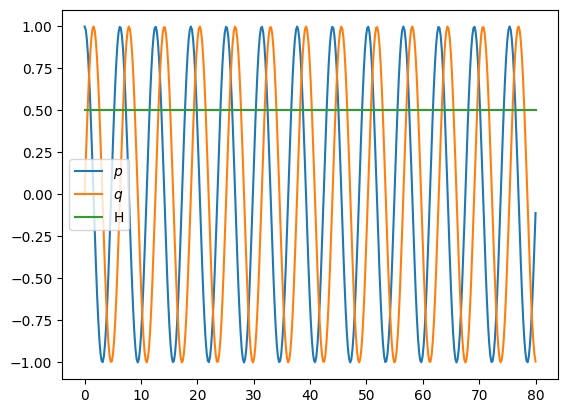

In [8]:
p, q = pq.T
H = 0.5 * (p ** 2 + q ** 2)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [9]:
OBSERVATIONS_END = 100
SPARSITY_FACTOR = 0.0

rng = np.random.default_rng(42)

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

rng = np.random.default_rng(seed=42)
M = np.ones_like(X_true).astype(bool)
sparse_mask = rng.choice([False, True], p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR], size=OBSERVATIONS_END)
M[:OBSERVATIONS_END, 1] = sparse_mask
M[:OBSERVATIONS_END, 2] = sparse_mask
M[OBSERVATIONS_END:, 1:3] = False
M[:, 3] = False

rng = np.random.default_rng(42)
#X = rng.uniform(-0.15, 0.15, size=X_true.shape)
X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]

In [10]:
ms_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

ms_graph.add_observable("t")
ms_graph.add_unknown_fn("t", "q", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
ms_graph.add_unknown_fn("t", "p", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})

ms_graph.add_known_fn("p", "p_dot", derivative)
ms_graph.add_known_fn("q", "q_dot", derivative)
ms_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

ms_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

ms_graph.add_aggregator(["p", "q"], "pq")
ms_graph.add_unknown_fn(
    "pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="big-kernel",
    kernel_parameters={
        "gaussian_width": KP(1.0, learnable=True),
        "gaussian_weight": KP(1.0, learnable=True, weight=True),
        "quadratic_constant": KP(1.0, learnable=True),
        "quadratic_weight": KP(1.0, learnable=True, weight=True),
        #"periodic_periodicity": KP(1.0 ,learnable=True),
        #"periodic_scale": KP(1.0, learnable=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        "cubic_constant": KP(1.0, learnable=True),
        "cubic_weight": KP(1.0, learnable=True, weight=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        #"poly_weight": KP(1.0, learnable=True, weight=True),
        #"poly_constant": KP(1.0, learnable=True),
        #"poly_exponant": KP(2.0, learnable=False),
        #"locally_periodic_periodicity": KP(1.0, learnable=True),
        #"locally_periodic_scale": KP(1.0, learnable=True),
        #"locally_periodic_locality_scale": KP(1.0, learnable=True),
        #"locally_periodic_weight": KP(1.0, learnable=True, weight=True)
    }
)
#ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="polynomial", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "exponent": KP(2.0, learnable=False)
#})
#ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="gaussian", kernel_parameters={
#    "scale": KP(1.0, learnable=True)
#})
ms_graph.add_known_fn("H", "grad_H", derivative)

ms_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
ms_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

ms_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
ms_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [11]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(ms_graph, X, M, OBSERVATIONS_END)

In [12]:
mse_p = np.mean((X_true[OBSERVATIONS_END:, 1] - X_init[OBSERVATIONS_END:, 1]) ** 2)
mse_q = np.mean((X_true[OBSERVATIONS_END:, 2] - X_init[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 1.4285039269617102e-05
Extrapolation MSE on Q = 1.411060875161878e-05


In [13]:
ms_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [14]:
Z = ms_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 1992.3216:   1%|          | 6846/1000000 [06:05<14:44:14, 18.72it/s]


## CGC Extrapolation

In [15]:
mse_p = jnp.mean((X_true[OBSERVATIONS_END:, 1] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((X_true[OBSERVATIONS_END:, 2] - Z[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 3.526136849702535e-07
Extrapolation MSE on Q = 3.2964915881359707e-07


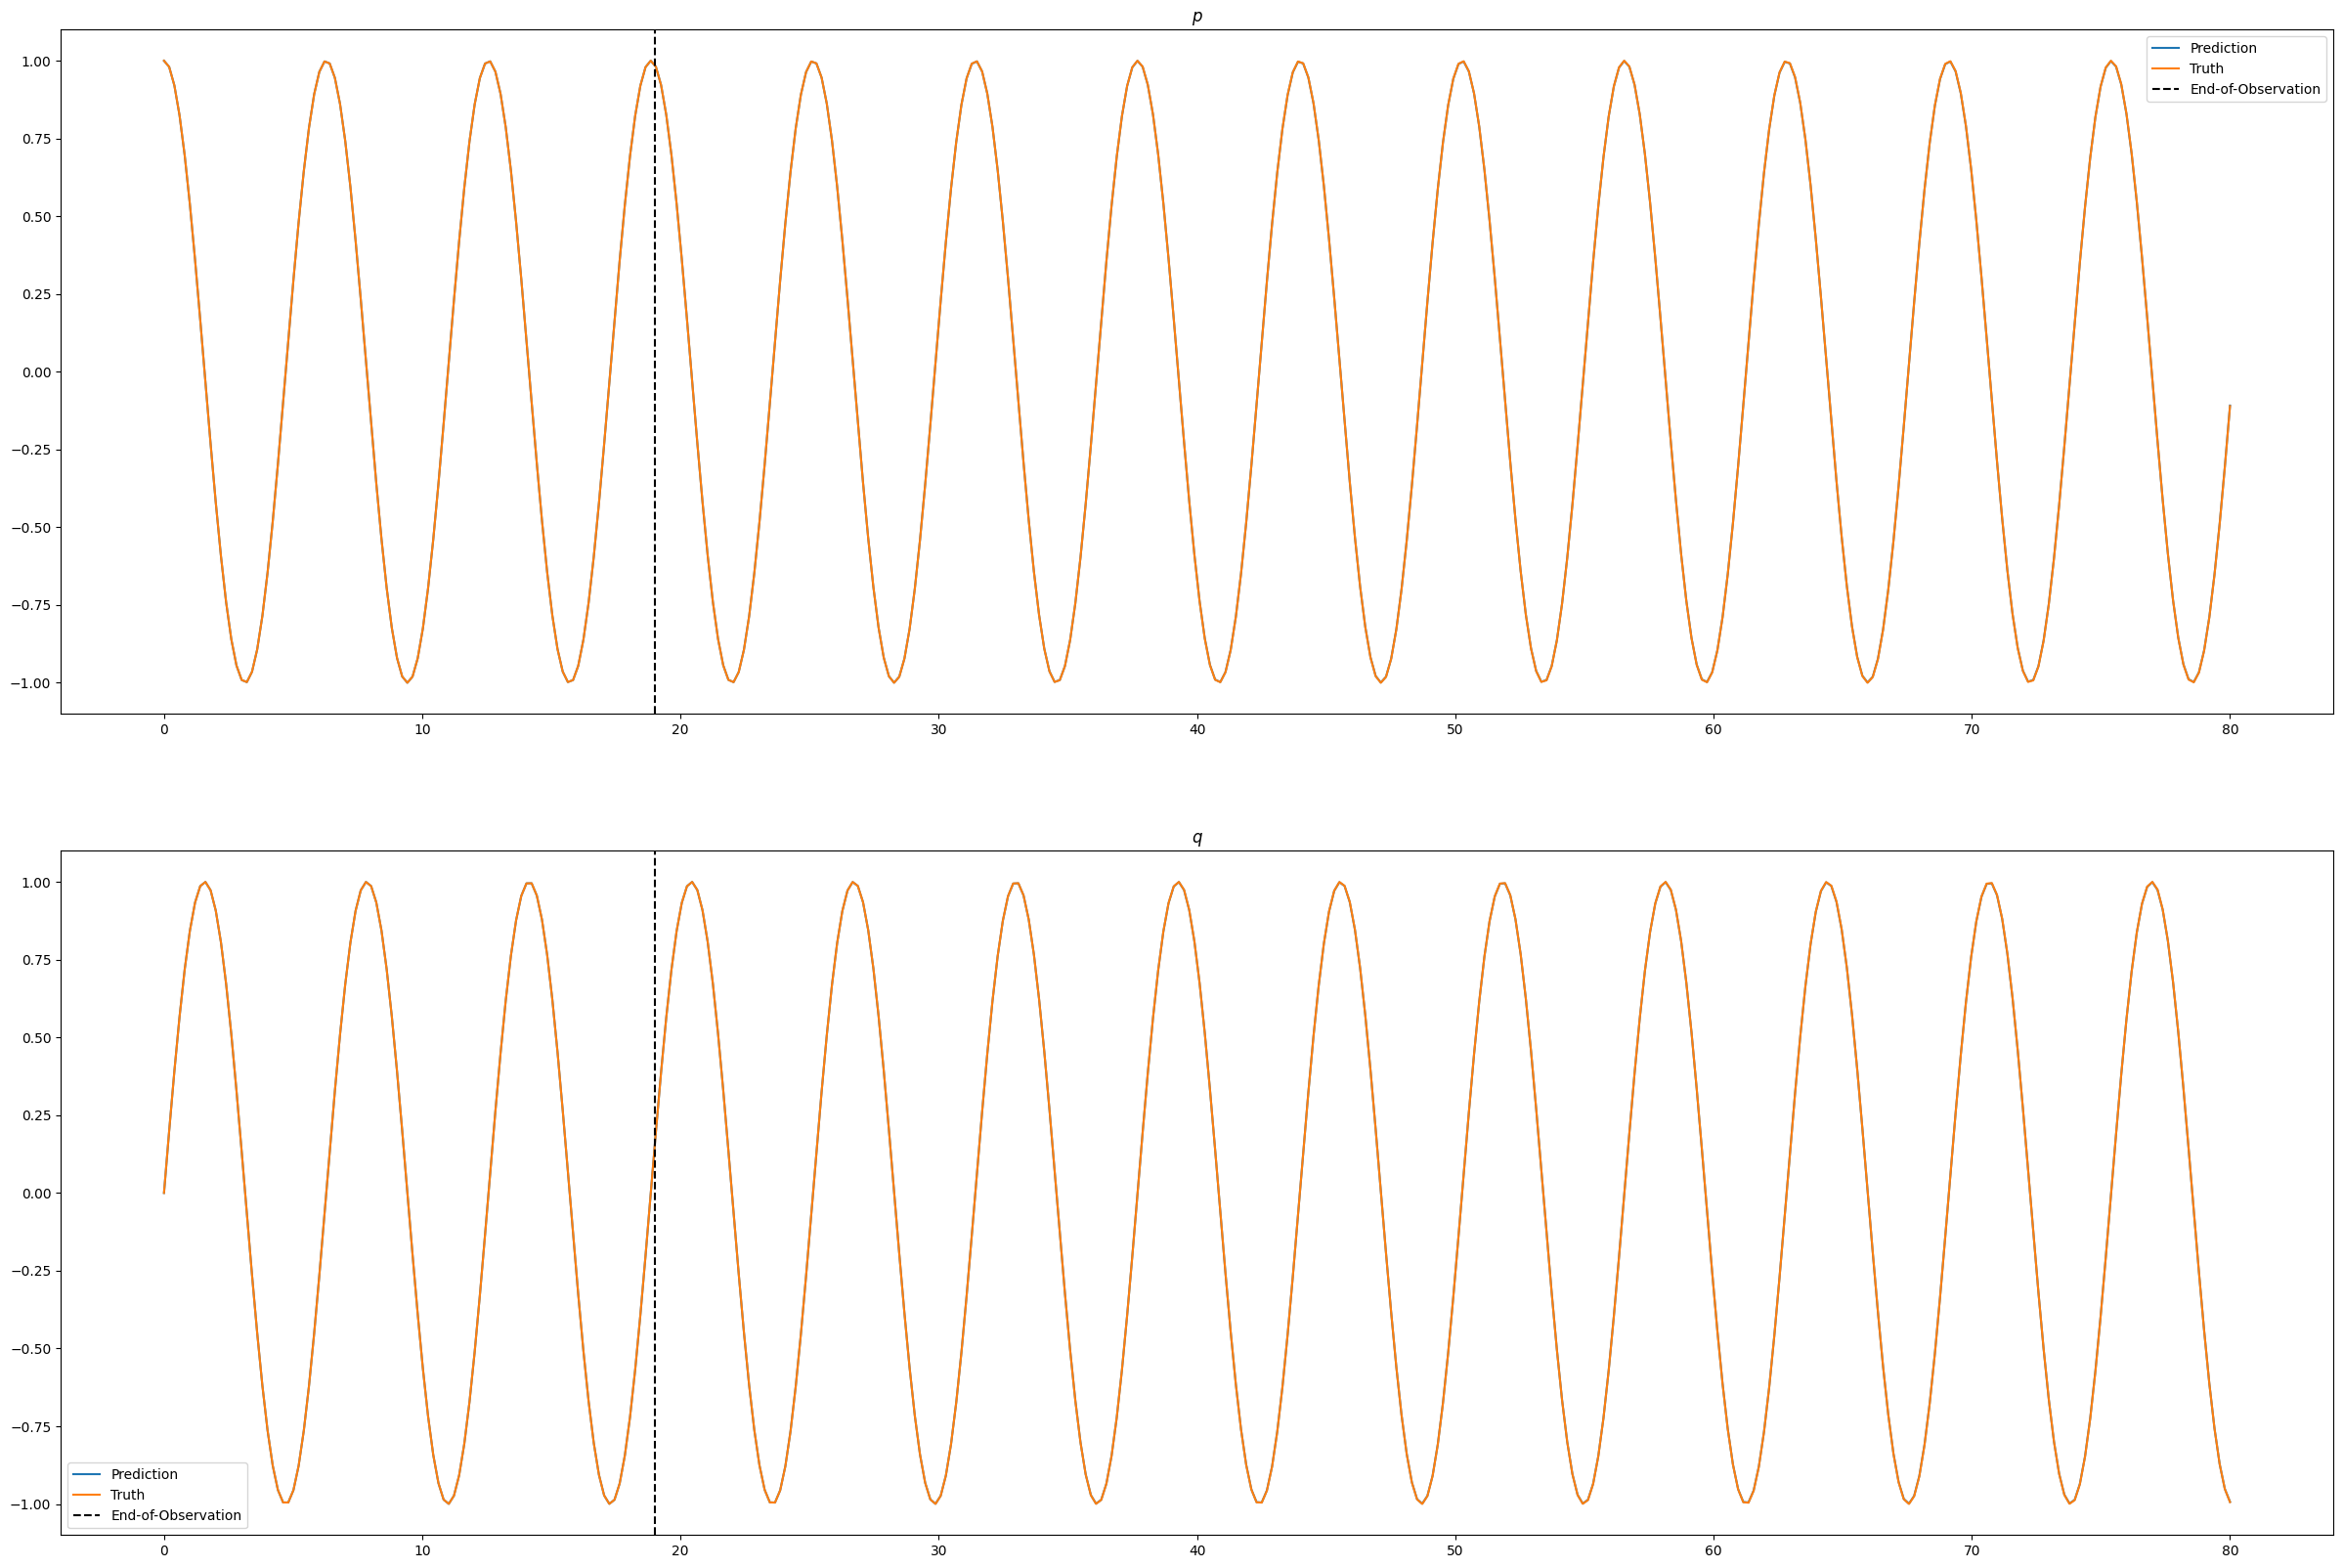

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

## Symplectic Integeration Extrapolation

In [30]:
import numpy as np
np.int = int

H_ms_est = get_hamiltonian_from(ms_graph, Z)
H_ms_est_grad = jax.jit(jax.grad(H_ms_est))

start_point = [p[OBSERVATIONS_END - 1], q[OBSERVATIONS_END - 1]]

t = np.linspace(0, 80, 400)
pq_symplectic = hamiltonian_symplectic_int(H_ms_est_grad, start_point, t[OBSERVATIONS_END - 1:])
pq_symplectic = jnp.squeeze(pq_symplectic)

In [31]:
mse_p = jnp.mean((p[OBSERVATIONS_END - 1:] - pq_symplectic[:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END - 1:] - pq_symplectic[:, 0]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 0.0040939698737339795
Extrapolation MSE on Q = 0.00414771996401501


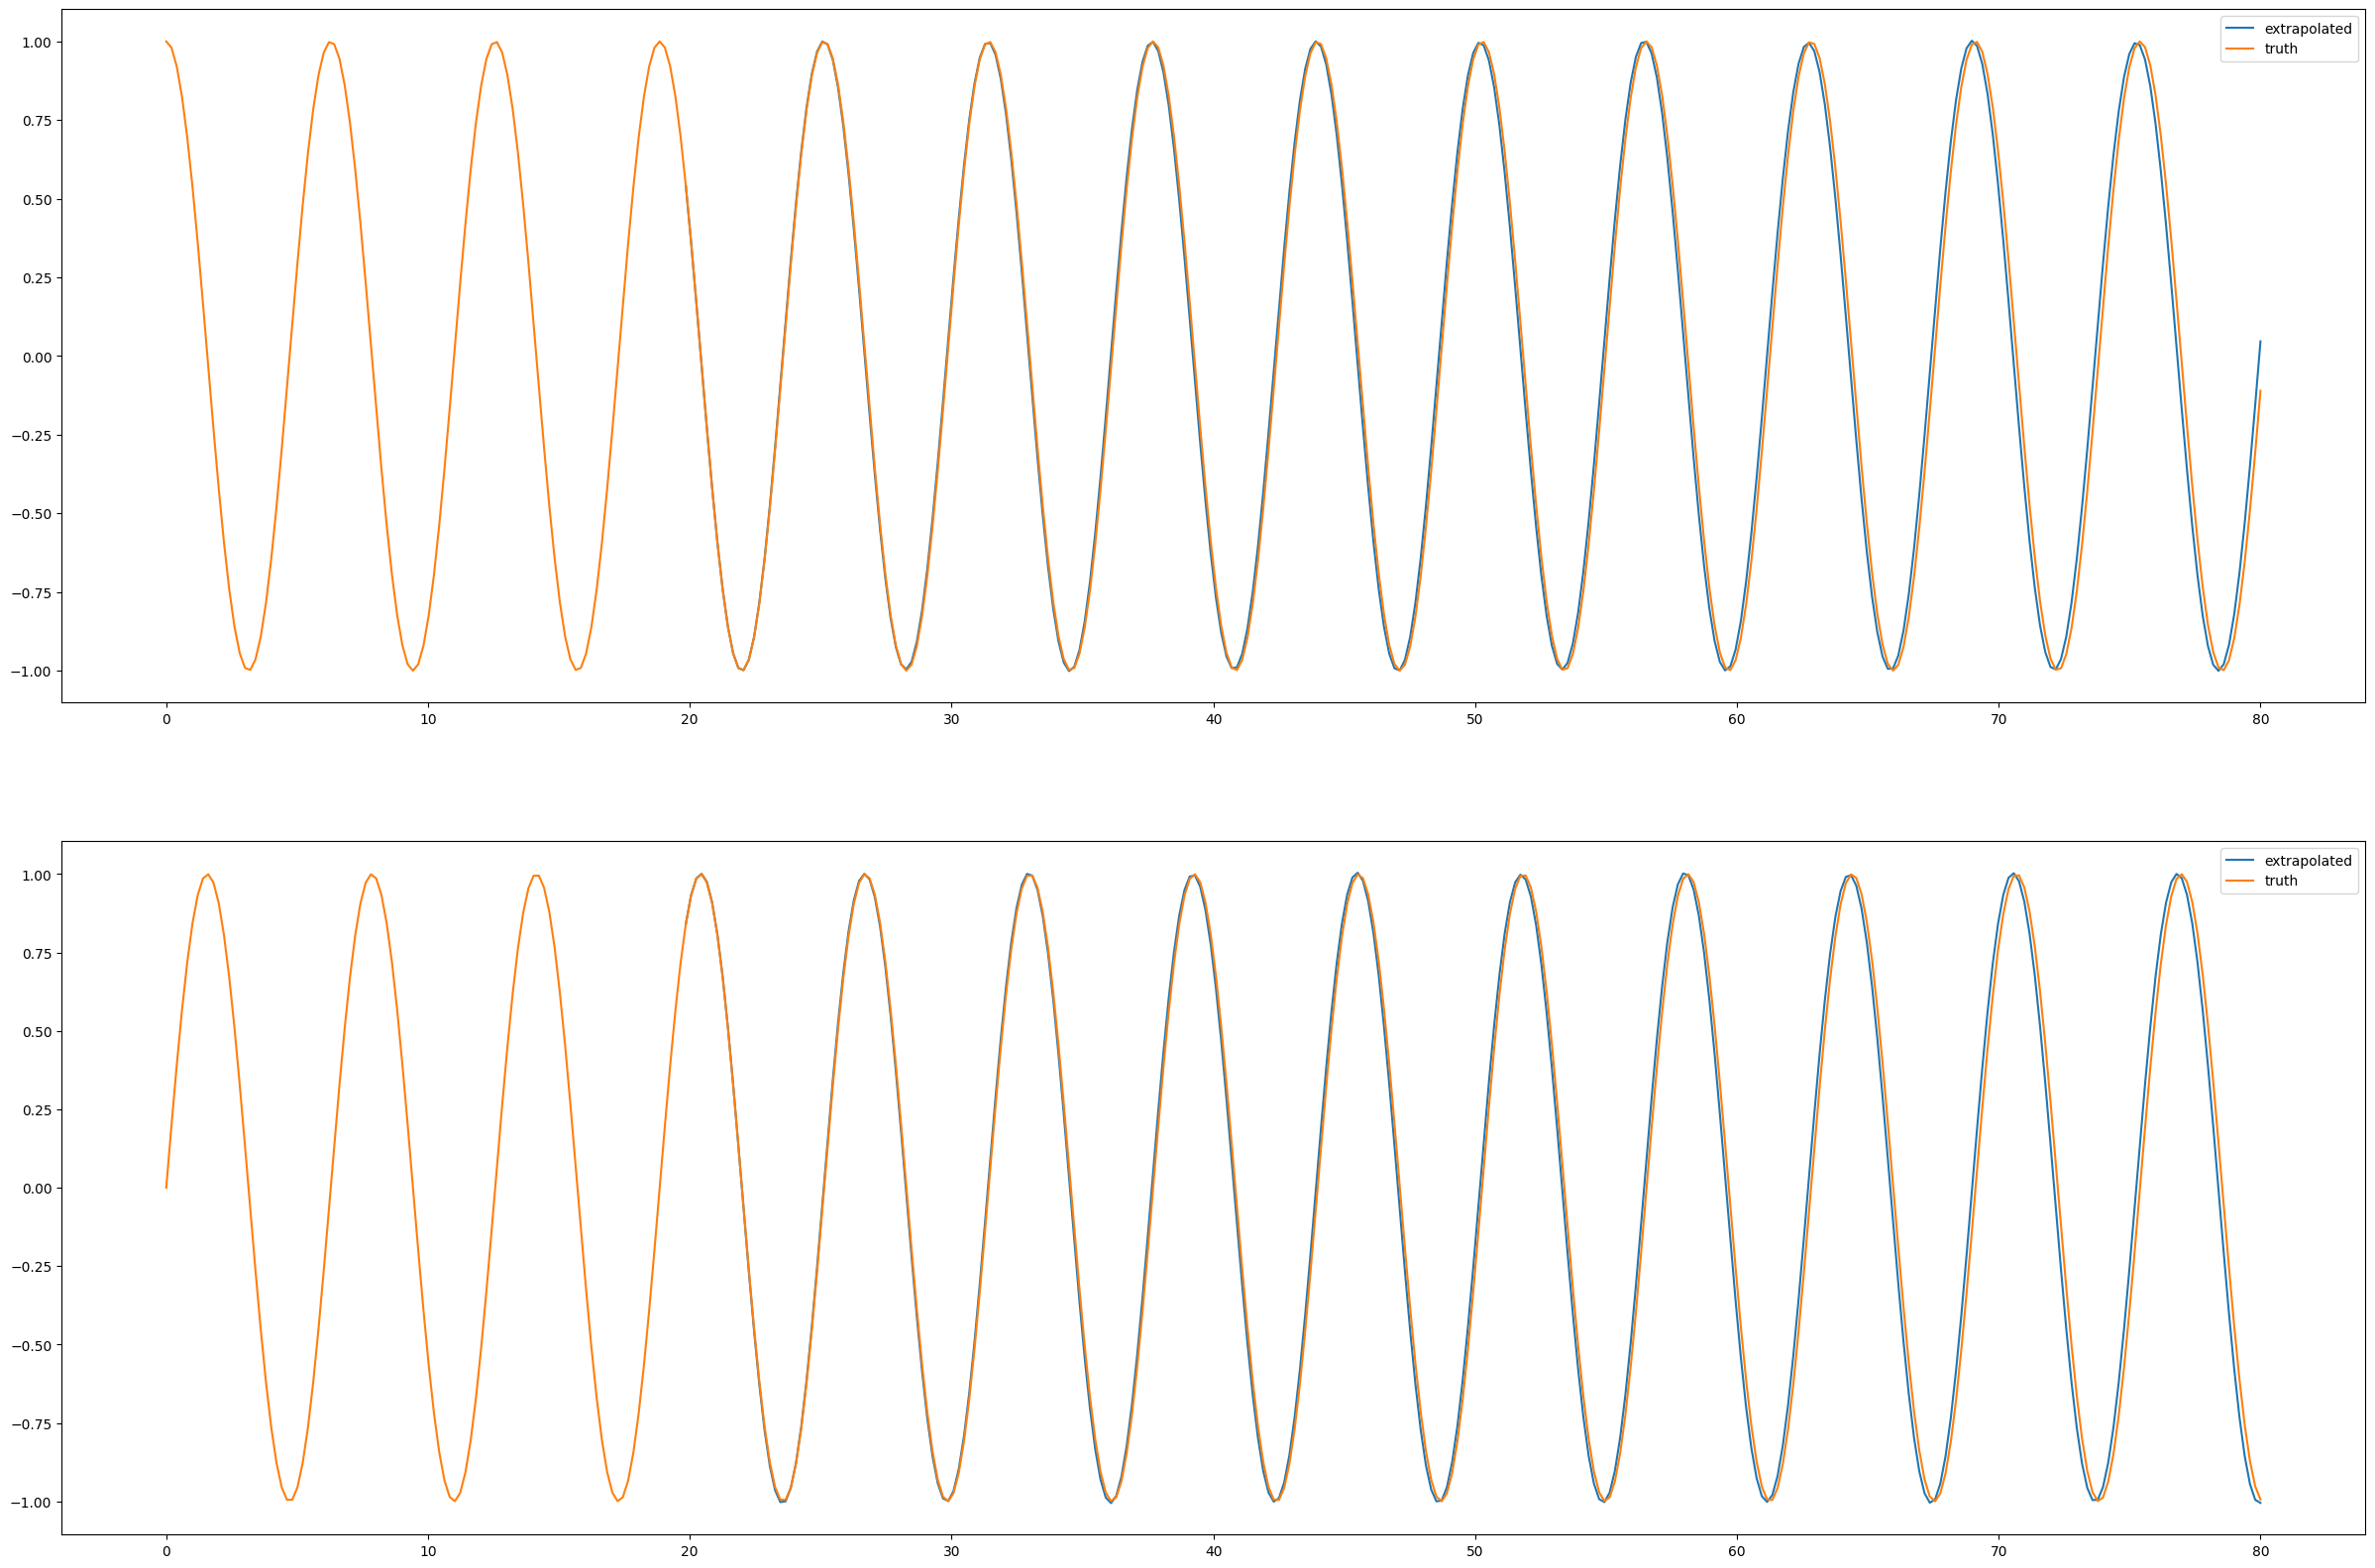

In [32]:
_, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t[OBSERVATIONS_END - 1:], pq_symplectic[:, 1], label="extrapolated")
axes[0].plot(t, p, label="truth")
axes[0].legend()
axes[1].plot(t[OBSERVATIONS_END - 1:], pq_symplectic[:, 0], label="extrapolated")
axes[1].plot(t, q, label="truth")
axes[1].legend()

# Two-Mass-Three-Springs System

## Data Generation

In [17]:
def m2s3_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 + (q2 - q1),
        -q2 - (q2 - q1),
        p1,
        p2
    ]
    
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(m2s3_system_ode, [0.1, -0.1, 0.2, -0.1], t)

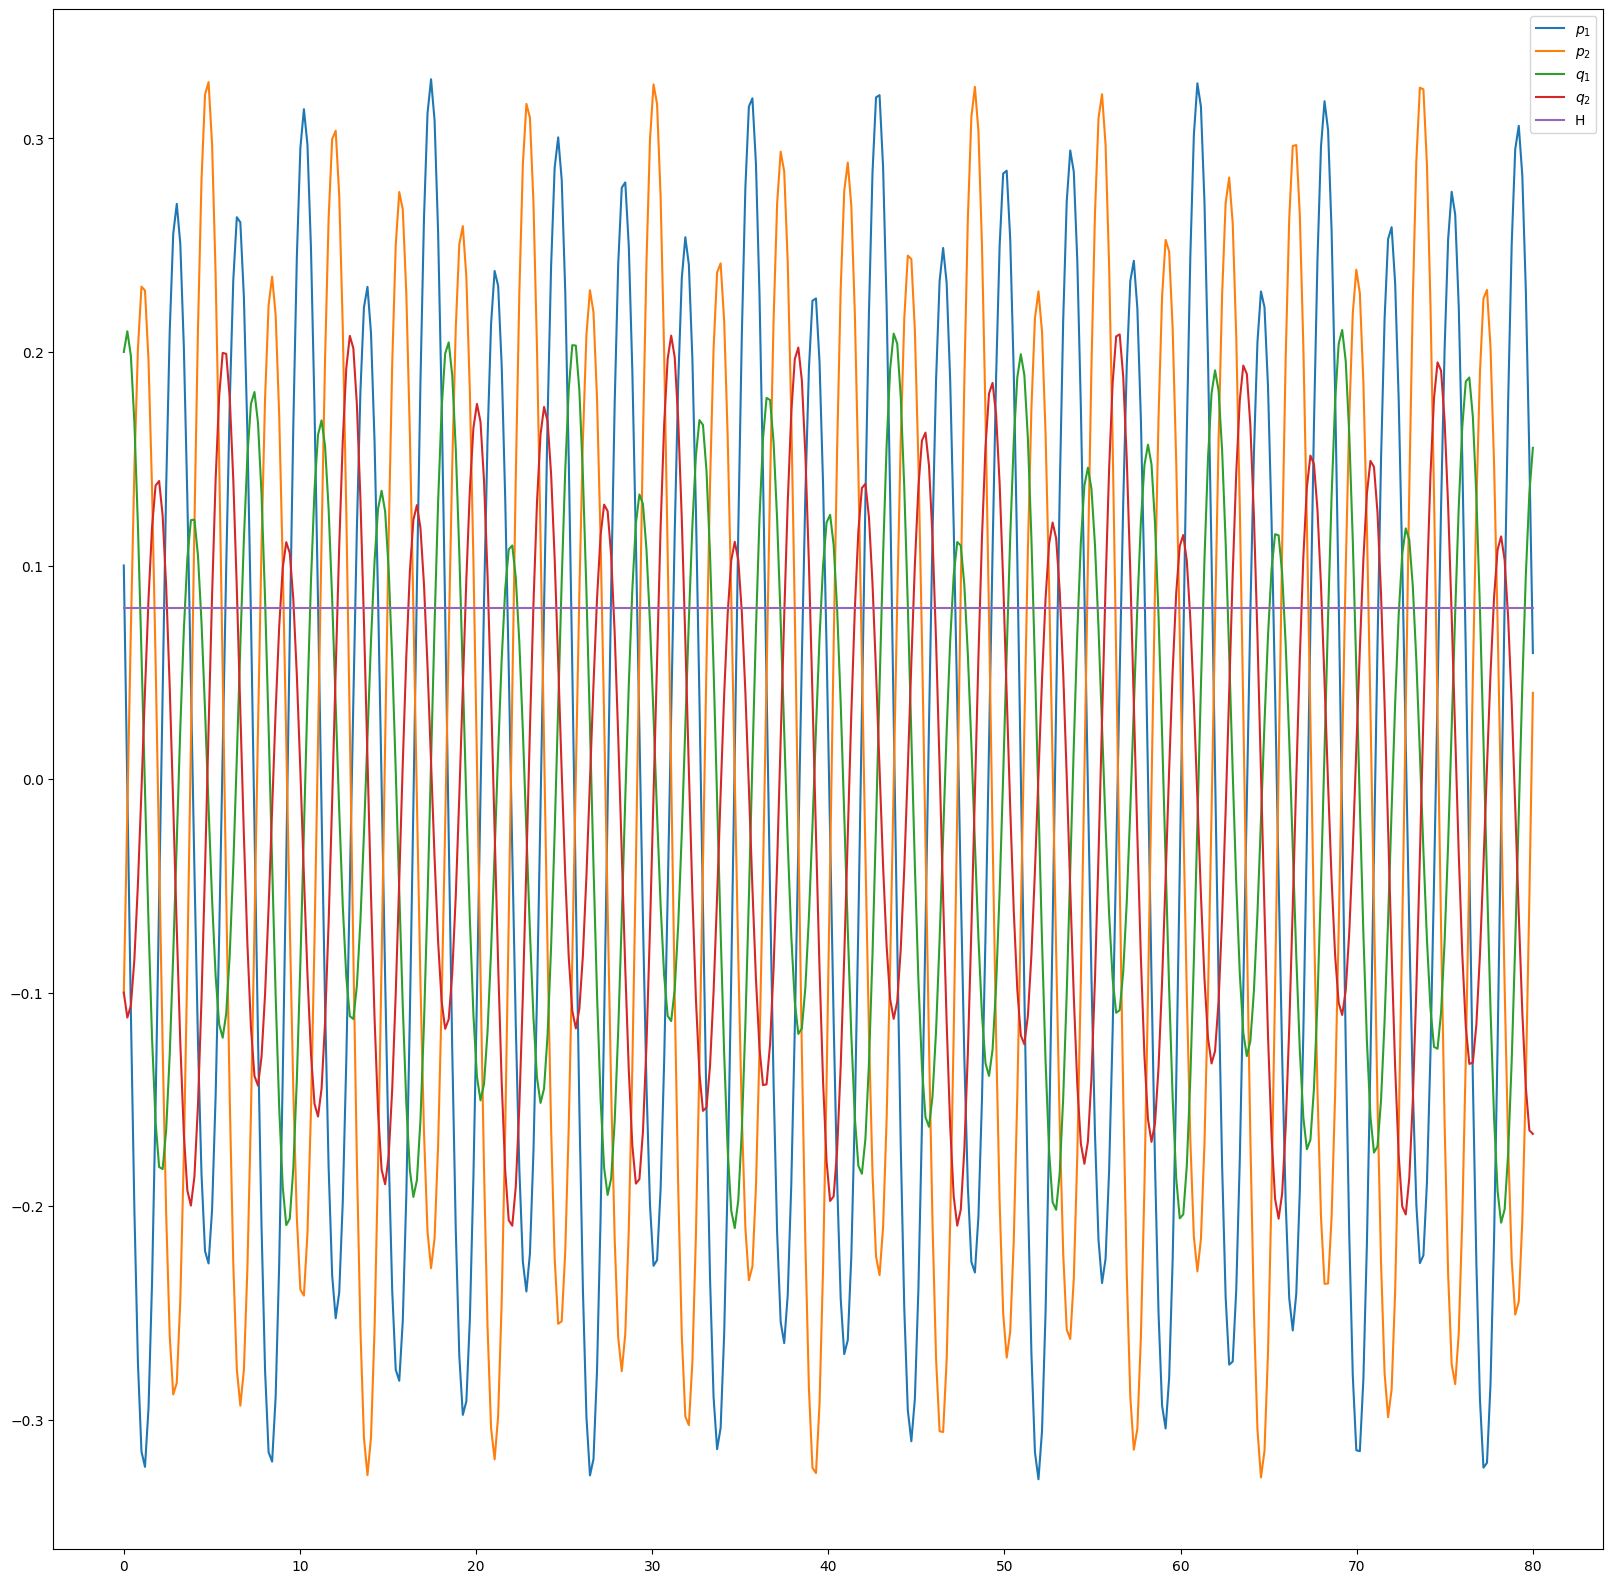

In [18]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + (q2 - q1) ** 2 + p1 ** 2 + p2 ** 2)
plt.figure(figsize=(20, 20))
plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [19]:
OBSERVATIONS_END = 100
SPARSITY_FACTOR = 0.0

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

rng = np.random.default_rng(seed=42)
observations_mask = rng.choice([False, True], size=OBSERVATIONS_END, p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR])

M = np.ones_like(X_true).astype(bool)
for i in range(1, 5):
    M[:OBSERVATIONS_END:, i] = observations_mask
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [20]:
rng = np.random.default_rng(seed=42)

m2s3_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

m2s3_graph.add_observable("t")
#m2s3_graph.add_unknown_fn("t", "p1", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#m2s3_graph.add_unknown_fn("t", "p2", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#m2s3_graph.add_unknown_fn("t", "q1", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#m2s3_graph.add_unknown_fn("t", "q2", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})

m2s3_graph.add_unknown_fn("t", "p1", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
m2s3_graph.add_unknown_fn("t", "p2", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
m2s3_graph.add_unknown_fn("t", "q1", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
m2s3_graph.add_unknown_fn("t", "q2", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})


m2s3_graph.add_known_fn("p1", "p1_dot", derivative)
m2s3_graph.add_known_fn("p2", "p2_dot", derivative)
m2s3_graph.add_known_fn("q1", "q1_dot", derivative)
m2s3_graph.add_known_fn("q2", "q2_dot", derivative)

m2s3_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
m2s3_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
m2s3_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

m2s3_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
m2s3_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

m2s3_graph.add_unknown_fn(
    "pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="big-kernel",
    kernel_parameters={
        "gaussian_width": KP(1.0, learnable=True),
        "gaussian_weight": KP(1.0, learnable=True, weight=True),
        "quadratic_constant": KP(1.0, learnable=True),
        "quadratic_weight": KP(1.0, learnable=True, weight=True),
        #"periodic_periodicity": KP(1.0 ,learnable=True),
        #"periodic_scale": KP(1.0, learnable=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        "cubic_constant": KP(1.0, learnable=True),
        "cubic_weight": KP(1.0, learnable=True, weight=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        #"poly_weight": KP(1.0, learnable=True, weight=True),
        #"poly_constant": KP(1.0, learnable=True),
        #"poly_exponant": KP(3.0, learnable=False),
        #"locally_periodic_periodicity": KP(1.0, learnable=True),
        #"locally_periodic_scale": KP(1.0, learnable=True),
        #"locally_periodic_locality_scale": KP(1.0, learnable=True),
        #"locally_periodic_weight": KP(1.0, learnable=True, weight=True)
    }
)
#m2s3_graph.add_unknown_fn("pq", "H_gaussian", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="gaussian", kernel_parameters={
#    "scale": KP(1.0, learnable=True),
#    "weight": KP(1.0, learnable=True, weight=True)
#})
#m2s3_graph.add_unknown_fn("pq", "H_quadratic", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="quadratic", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "weight": KP(1.0, learnable=True, weight=True)
#})
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, kernel="quadratic", kernel_parameters={"constant": KP(1.0, learnable=True)})
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="polynomial", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "exponent": KP(1.0, learnable=True)
#    })
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="quadratic", kernel_parameters={"constant": KP(1.0, learnable=True)})
#m2s3_graph.add_aggregator(["H_gaussian", "H_quadratic"], "H_components")
#m2s3_graph.add_known_fn("H_components", "H", lambda H_components: H_components[:, 0] + H_components[:, 1])
#
#m2s3_graph.add_known_fn("H_gaussian", "H_gaussian_grad", derivative)
#m2s3_graph.add_known_fn("H_quadratic", "H_quadratic_grad", derivative)
#m2s3_graph.add_aggregator(["H_gaussian_grad", "H_quadratic_grad"], "H_grad_components")
#m2s3_graph.add_known_fn("H_grad_components", "grad_H", lambda C: C[:, 0, :] + C[:, 1, :])

#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="gaussian", kernel_parameters={
#    "scale": KP(1.0),
#})

m2s3_graph.add_known_fn("H", "grad_H", derivative)

m2s3_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

m2s3_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

m2s3_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
m2s3_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [21]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(m2s3_graph, X, M, OBSERVATIONS_END)

In [22]:
mse_p = np.mean((X_init[OBSERVATIONS_END:, 1:3] - X_true[OBSERVATIONS_END:, 1:3]) ** 2)
mse_q = np.mean((X_init[OBSERVATIONS_END:, 3:5] - X_true[OBSERVATIONS_END:, 3:5]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 7.078181099802957e-07
Extrapolation MSE on Q = 4.228035894447776e-07


In [23]:
m2s3_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [24]:
Z = m2s3_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 79.3419:   1%|          | 8452/1000000 [15:58<31:14:42,  8.82it/s]


## CGC Extrapolation

In [26]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 3]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 4]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1}")
print(f"Extrapolation MSE on Q1 = {mse_q1}")
print(f"Extrapolation MSE on P2 = {mse_p2}")
print(f"Extrapolation MSE on Q2 = {mse_q2}")

Extrapolation MSE on P1 = 1.8458751910575276e-06
Extrapolation MSE on Q1 = 6.319045968216909e-07
Extrapolation MSE on P2 = 1.8102444739780314e-06
Extrapolation MSE on Q2 = 6.061626214815129e-07


In [25]:
mse_p = jnp.mean((X_true[OBSERVATIONS_END:, 1:3] - Z[OBSERVATIONS_END:, 1:3]) ** 2)
mse_q = jnp.mean((X_true[OBSERVATIONS_END:, 3:5] - Z[OBSERVATIONS_END:, 3:5]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 1.8280598325177793e-06
Extrapolation MSE on Q = 6.190336091516018e-07


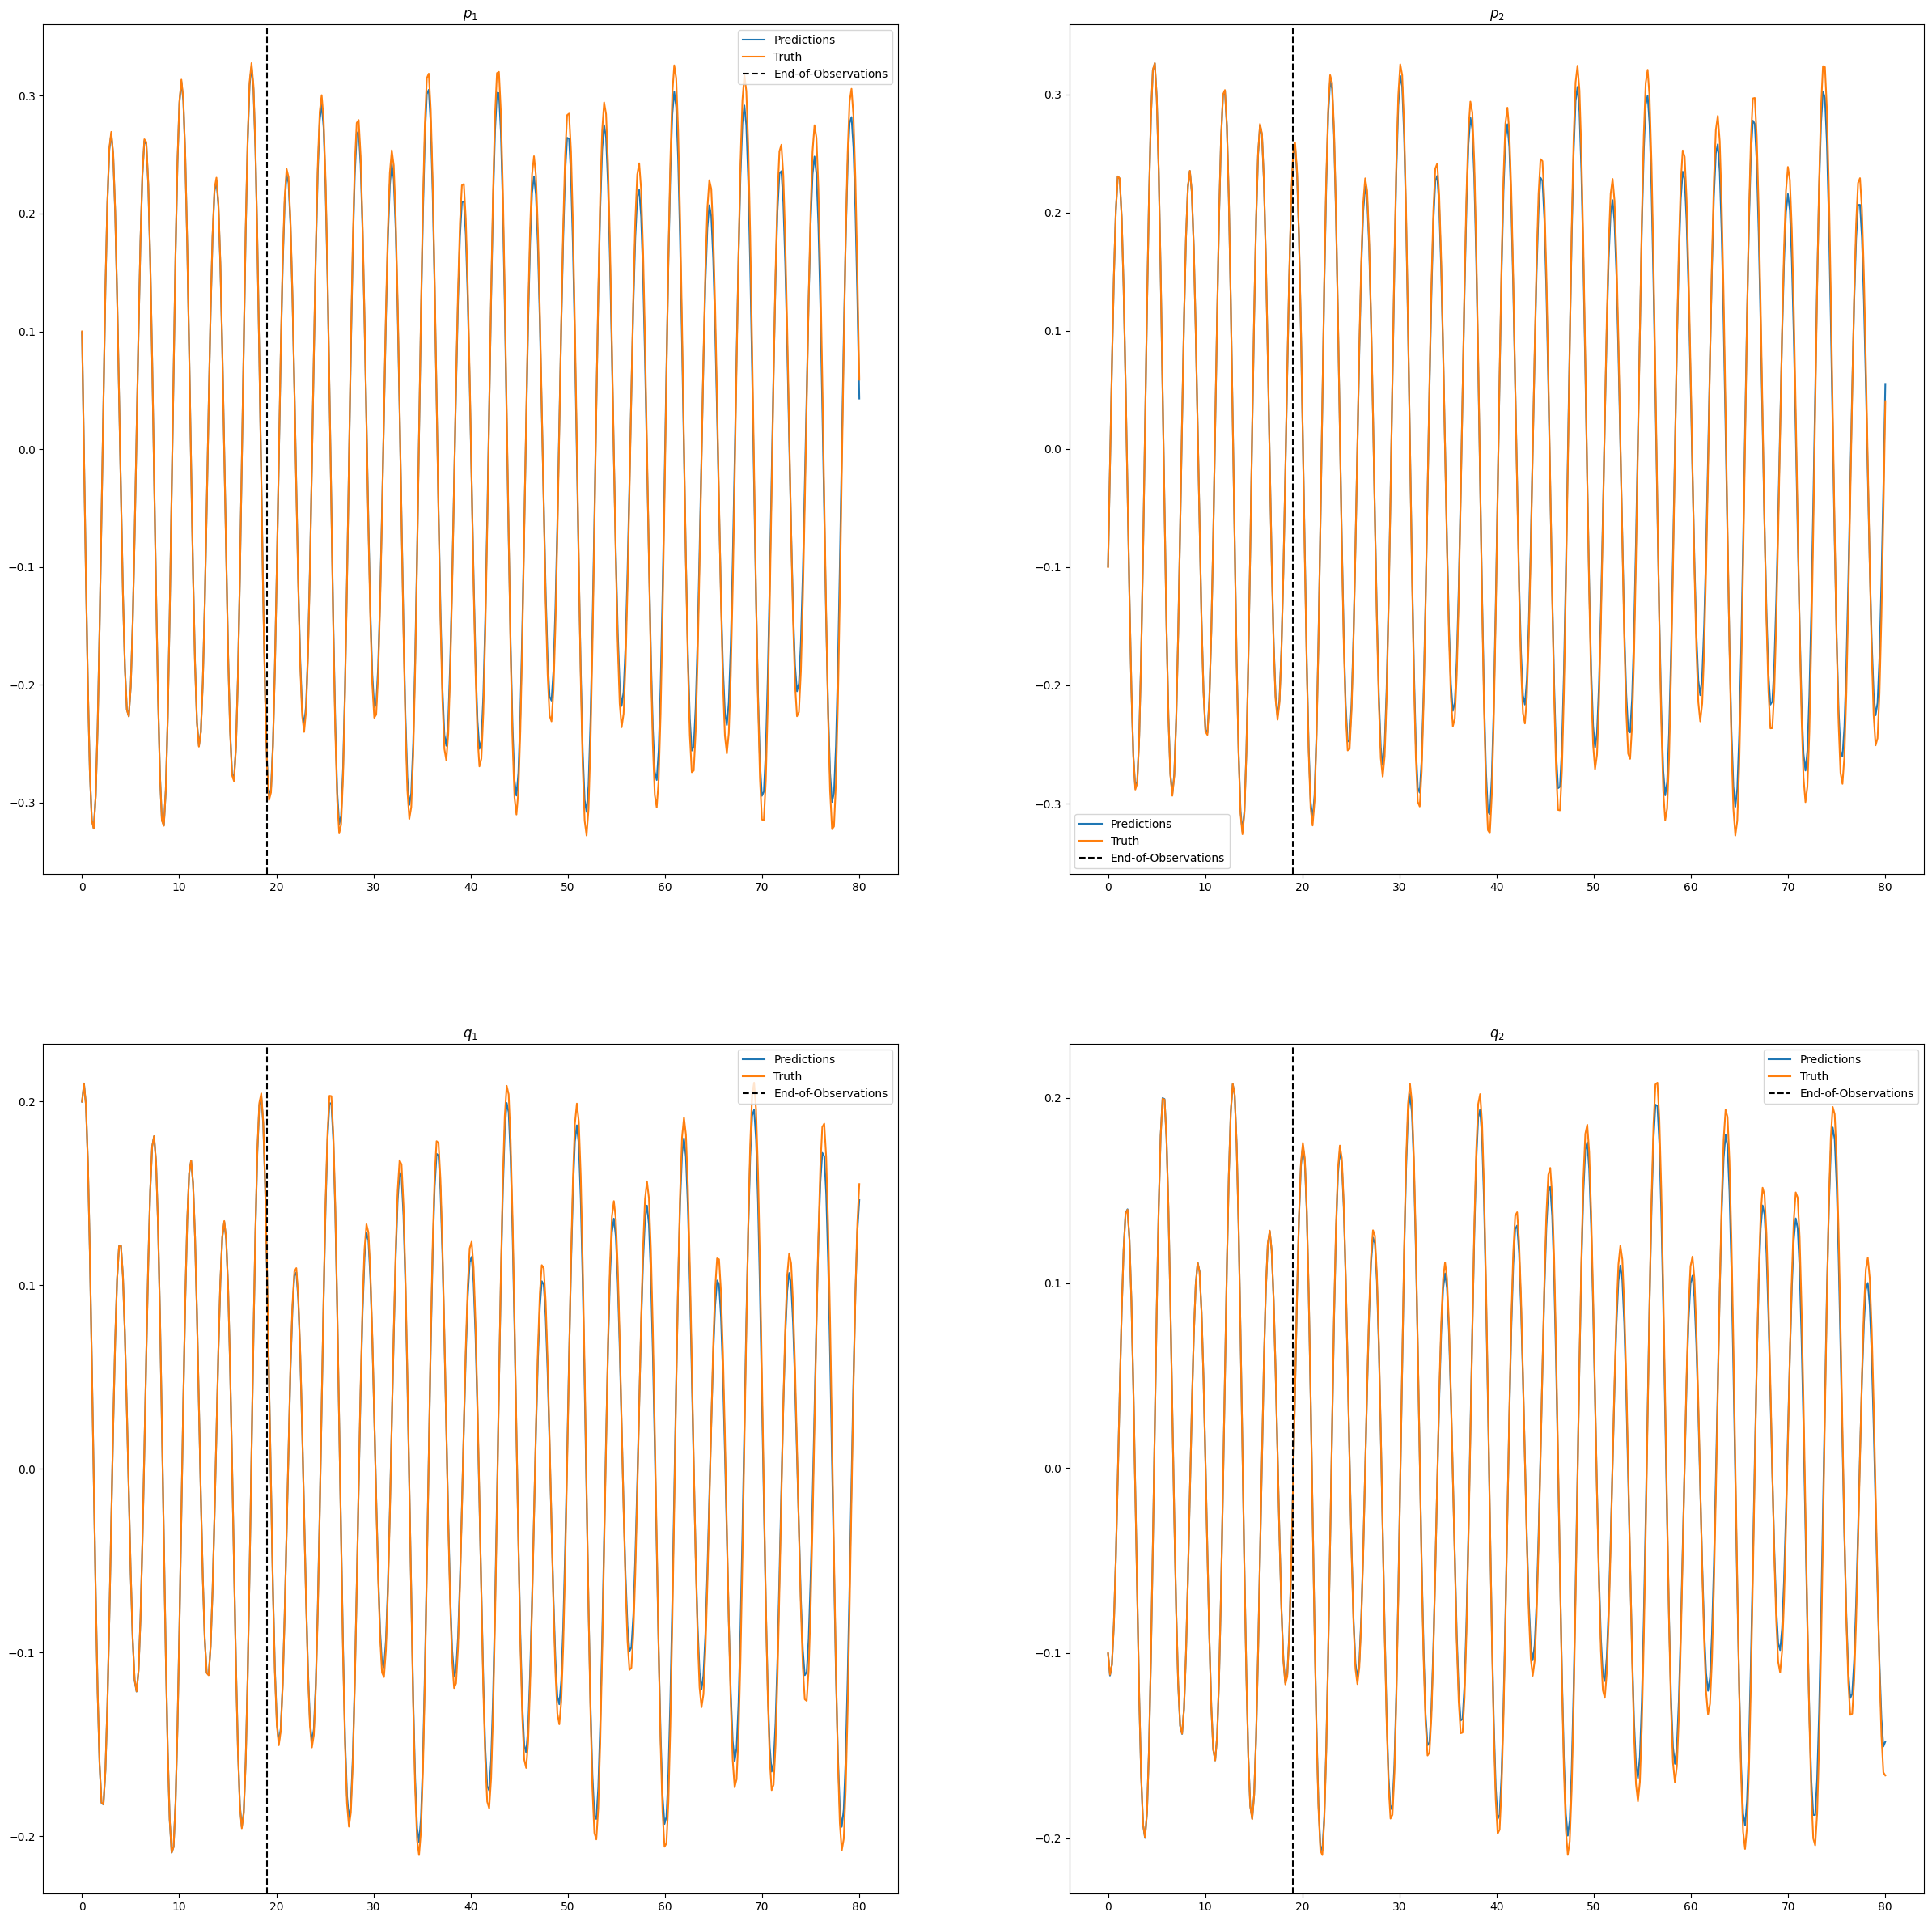

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(19, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

## Symplectic Integeration Extrapolation

In [41]:
import numpy as np

np.int = int

H_m2s3_est = get_hamiltonian_from(m2s3_graph, Z)
H_m2s3_est_grad = jax.jit(jax.grad(H_m2s3_est))

start_point = [p1[OBSERVATIONS_END - 1], p2[OBSERVATIONS_END - 1], q1[OBSERVATIONS_END - 1], q2[OBSERVATIONS_END - 1]]

pq_symplectic = hamiltonian_symplectic_int(H_m2s3_est_grad, start_point, t[OBSERVATIONS_END - 1:])
pq_symplectic = jnp.squeeze(pq_symplectic)

In [42]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END - 1:] - pq_symplectic[:, 1, 0]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END - 1:] - pq_symplectic[:, 0, 0]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END - 1:] - pq_symplectic[:, 1, 1]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END - 1:] - pq_symplectic[:, 0, 1]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.505743286
Extrapolation MSE on Q1 = 0.371278606
Extrapolation MSE on P2 = 0.509884861
Extrapolation MSE on Q2 = 0.375282564


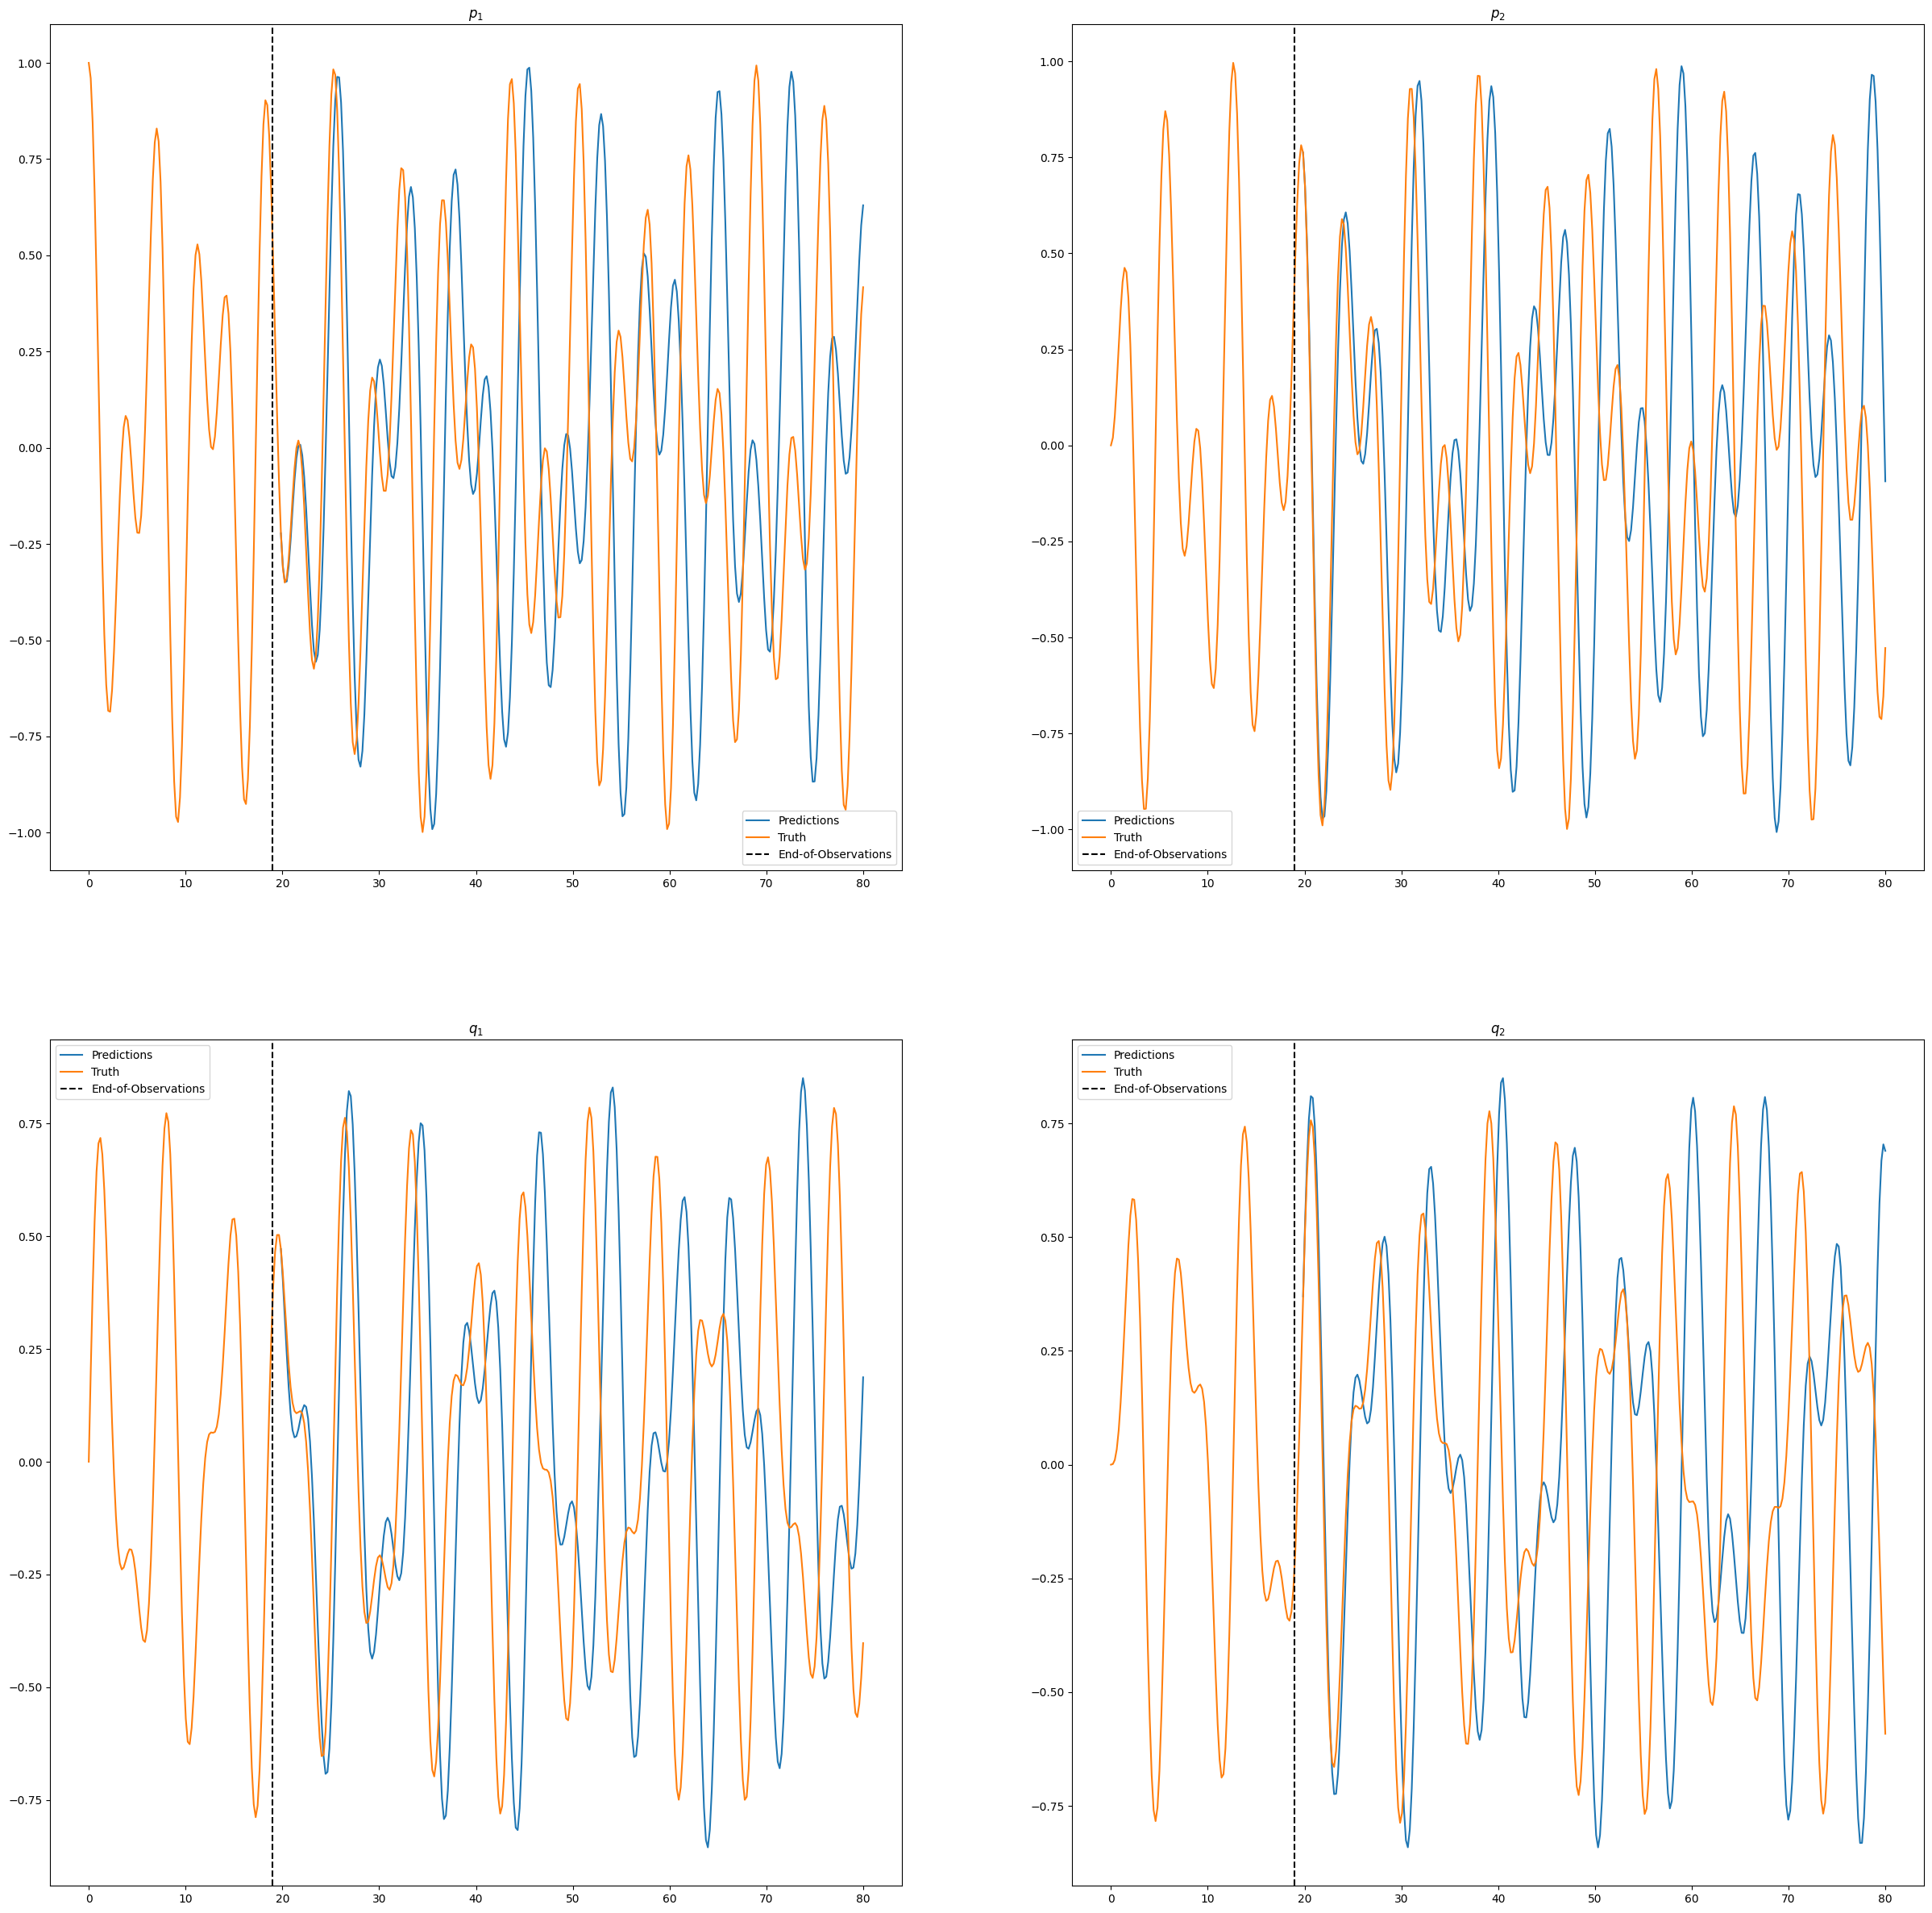

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "est", "truth", "label"])

plots_data = [
    PlotData((0, 0), pq_symplectic[:, 1, 0], p1, "$p_1$"),
    PlotData((0, 1), pq_symplectic[:, 1, 1], p2, "$p_2$"),
    PlotData((1, 0), pq_symplectic[:, 0, 0], q1, "$q_1$"),
    PlotData((1, 1), pq_symplectic[:, 0, 1], q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t[OBSERVATIONS_END - 1 :], data.est, label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(19, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Hénon–Heiles System

## Data Generation

In [26]:
def hh_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 - 2 * q1 * q2,
        -q2 - q1 ** 2 + q2 ** 2,
        p1,
        p2
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(hh_system_ode, [0.1, -0.1, 0.2, -0.1], t)


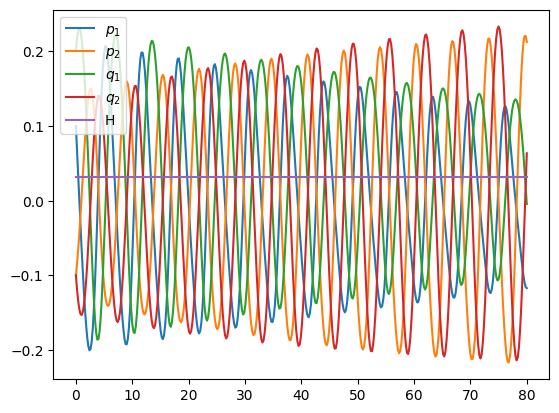

In [27]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + p1 ** 2 + p2 ** 2) + q2 * q1 ** 2 - (1/3) * q2 ** 3

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [28]:
OBSERVATIONS_END = 100
SPARSITY_FACTOR = 0.0


X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

rng = np.random.default_rng(seed=42)
observations_mask = rng.choice([False, True], size=OBSERVATIONS_END, p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR])

M = np.ones_like(X_true).astype(bool)
for i in range(1, 5):
    M[:OBSERVATIONS_END:, i] = observations_mask
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [29]:
rng = np.random.default_rng(seed=42)

hh_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

hh_graph.add_observable("t")
#hh_graph.add_unknown_fn("t", "p1", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#hh_graph.add_unknown_fn("t", "p2", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#hh_graph.add_unknown_fn("t", "q1", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})
#hh_graph.add_unknown_fn("t", "q2", alpha=0.01, kernel="locally-periodic", kernel_parameters={
#    "locality_scale": KP(1.0, learnable=True),
#    "period_scale": KP(1.0, learnable=True),
#    "period": KP(1.0, learnable=True)
#})

hh_graph.add_unknown_fn("t", "p1", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
hh_graph.add_unknown_fn("t", "p2", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
hh_graph.add_unknown_fn("t", "q1", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
hh_graph.add_unknown_fn("t", "q2", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})


hh_graph.add_known_fn("p1", "p1_dot", derivative)
hh_graph.add_known_fn("p2", "p2_dot", derivative)
hh_graph.add_known_fn("q1", "q1_dot", derivative)
hh_graph.add_known_fn("q2", "q2_dot", derivative)

hh_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
hh_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
hh_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

hh_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
hh_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

hh_graph.add_unknown_fn(
    "pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="big-kernel",
    kernel_parameters={
        "gaussian_width": KP(1.0, learnable=True),
        "gaussian_weight": KP(1.0, learnable=True, weight=True),
        "quadratic_constant": KP(1.0, learnable=True),
        "quadratic_weight": KP(1.0, learnable=True, weight=True),
        #"periodic_periodicity": KP(1.0 ,learnable=True),
        #"periodic_scale": KP(1.0, learnable=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        "cubic_constant": KP(1.0, learnable=True),
        "cubic_weight": KP(1.0, learnable=True, weight=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        #"poly_weight": KP(1.0, learnable=True, weight=True),
        #"poly_constant": KP(1.0, learnable=True),
        #"poly_exponant": KP(3.0, learnable=False),
        #"locally_periodic_periodicity": KP(1.0, learnable=True),
        #"locally_periodic_scale": KP(1.0, learnable=True),
        #"locally_periodic_locality_scale": KP(1.0, learnable=True),
        #"locally_periodic_weight": KP(1.0, learnable=True, weight=True)
    }
)
#m2s3_graph.add_unknown_fn("pq", "H_gaussian", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="gaussian", kernel_parameters={
#    "scale": KP(1.0, learnable=True),
#    "weight": KP(1.0, learnable=True, weight=True)
#})
#m2s3_graph.add_unknown_fn("pq", "H_quadratic", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="quadratic", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "weight": KP(1.0, learnable=True, weight=True)
#})
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, kernel="quadratic", kernel_parameters={"constant": KP(1.0, learnable=True)})
#hh_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="polynomial", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "exponent": KP(3.0, learnable=False)
#    })
#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="quadratic", kernel_parameters={"constant": KP(1.0, learnable=True)})
#m2s3_graph.add_aggregator(["H_gaussian", "H_quadratic"], "H_components")
#m2s3_graph.add_known_fn("H_components", "H", lambda H_components: H_components[:, 0] + H_components[:, 1])
#
#m2s3_graph.add_known_fn("H_gaussian", "H_gaussian_grad", derivative)
#m2s3_graph.add_known_fn("H_quadratic", "H_quadratic_grad", derivative)
#m2s3_graph.add_aggregator(["H_gaussian_grad", "H_quadratic_grad"], "H_grad_components")
#m2s3_graph.add_known_fn("H_grad_components", "grad_H", lambda C: C[:, 0, :] + C[:, 1, :])

#m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="quadratic + gaussian", kernel_parameters={
#    "gaussian_scale": KP(1.0),
#    "gaussian_weight": KP(1.0, weight=True),
#    "quadratic_constant": KP(1.0),
#    "quadratic_weight": KP(1.0, weight=True)
#})

hh_graph.add_known_fn("H", "grad_H", derivative)

hh_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

hh_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

hh_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
hh_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [30]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(hh_graph, X, M, OBSERVATIONS_END)

In [31]:
mse_p = np.mean((X_init[OBSERVATIONS_END:, 1:3] - X_true[OBSERVATIONS_END:, 1:3]) ** 2)
mse_q = np.mean((X_init[OBSERVATIONS_END:, 3:5] - X_true[OBSERVATIONS_END:, 3:5]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 0.0002392561085551094
Extrapolation MSE on Q = 0.0002765004103993807


In [32]:
hh_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [33]:
Z = hh_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 3.7975:   1%|          | 11410/1000000 [21:35<31:10:18,  8.81it/s]


In [72]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 3]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 4]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.002604423
Extrapolation MSE on Q1 = 0.002907983
Extrapolation MSE on P2 = 0.001075476
Extrapolation MSE on Q2 = 0.001181765


In [34]:
mse_p = jnp.mean((X_true[OBSERVATIONS_END:, 1:3] - Z[OBSERVATIONS_END:, 1:3]) ** 2)
mse_q = jnp.mean((X_true[OBSERVATIONS_END:, 3:5] - Z[OBSERVATIONS_END:, 3:5]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 0.0002951013454913596
Extrapolation MSE on Q = 0.0003568815824956619


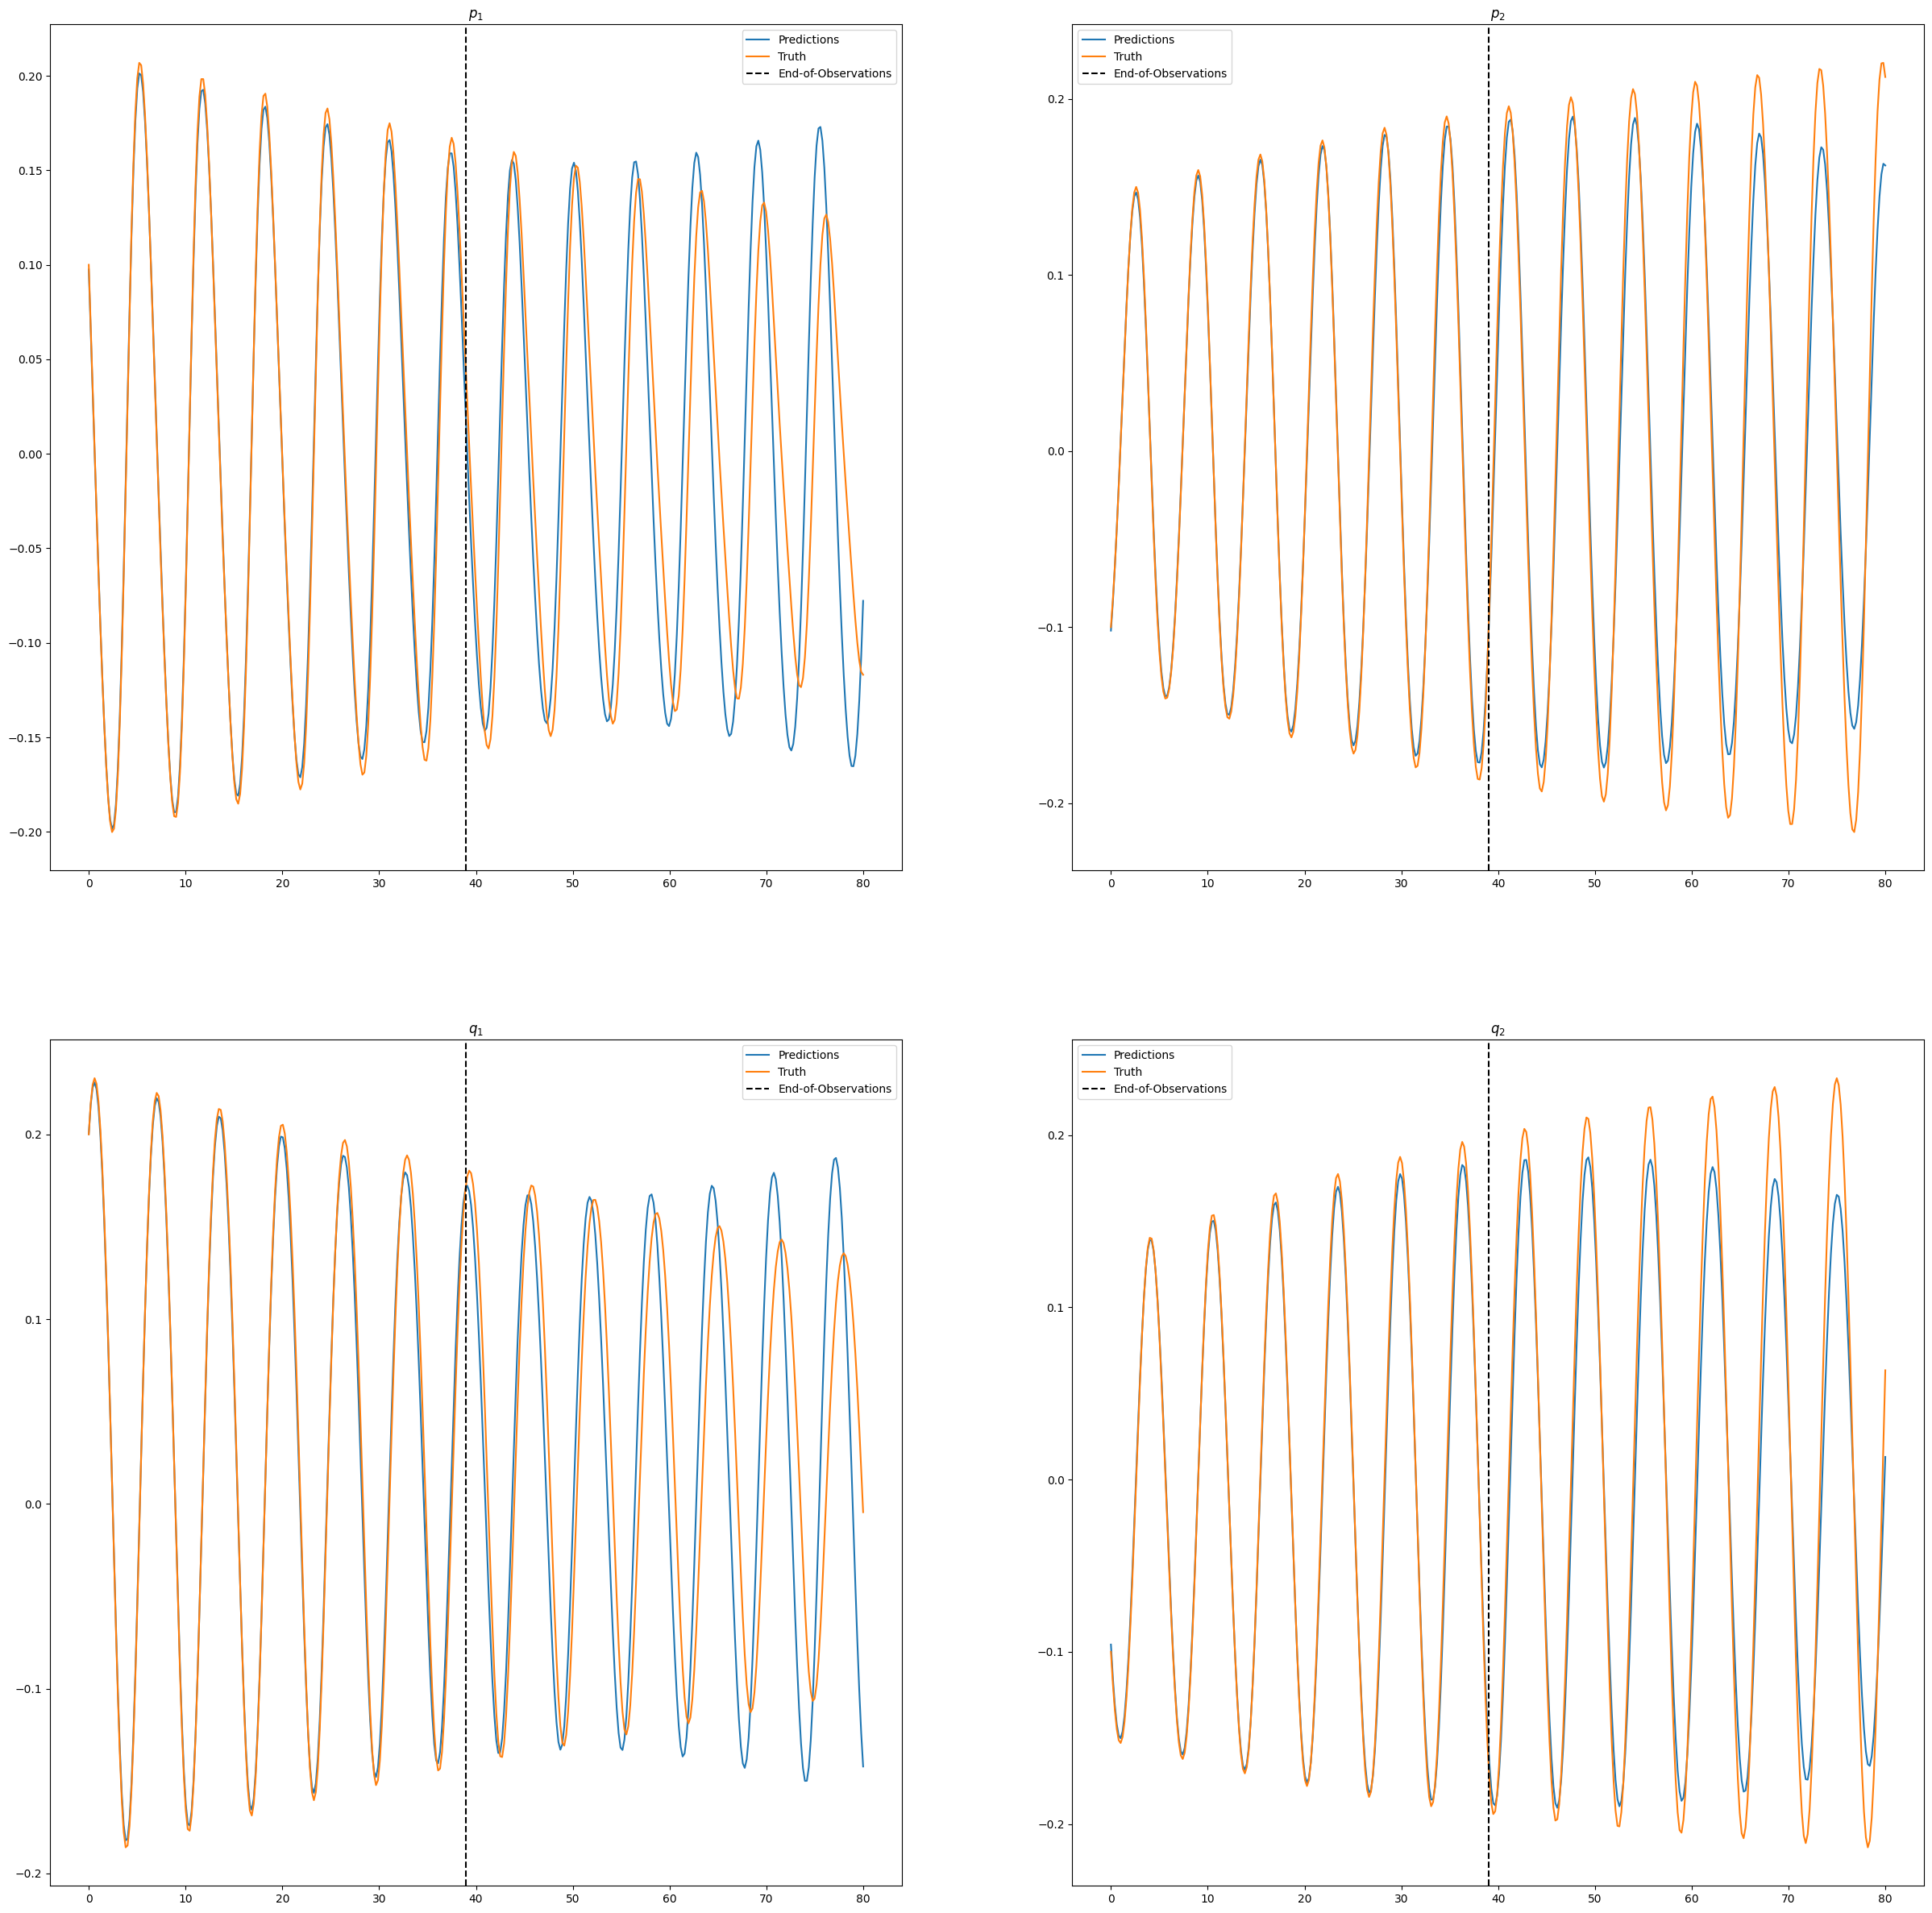

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

In [41]:
import numpy as np

np.int = int

H_hh_est = get_hamiltonian_from(hh_graph, Z)
H_hh_est_grad = jax.jit(jax.grad(H_hh_est))

start_point = [p1[OBSERVATIONS_END - 1], p2[OBSERVATIONS_END - 1], q1[OBSERVATIONS_END - 1], q2[OBSERVATIONS_END - 1]]


pq_symplectic = hamiltonian_symplectic_int(H_hh_est_grad, start_point, t[OBSERVATIONS_END - 1:], order=2)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [42]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END - 1:] - pq_symplectic[:, 1, 0]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END - 1:] - pq_symplectic[:, 0, 0]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END - 1:] - pq_symplectic[:, 1, 1]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END - 1:] - pq_symplectic[:, 0, 1]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.001236848
Extrapolation MSE on Q1 = 0.001414328
Extrapolation MSE on P2 = 0.001834982
Extrapolation MSE on Q2 = 0.003098212


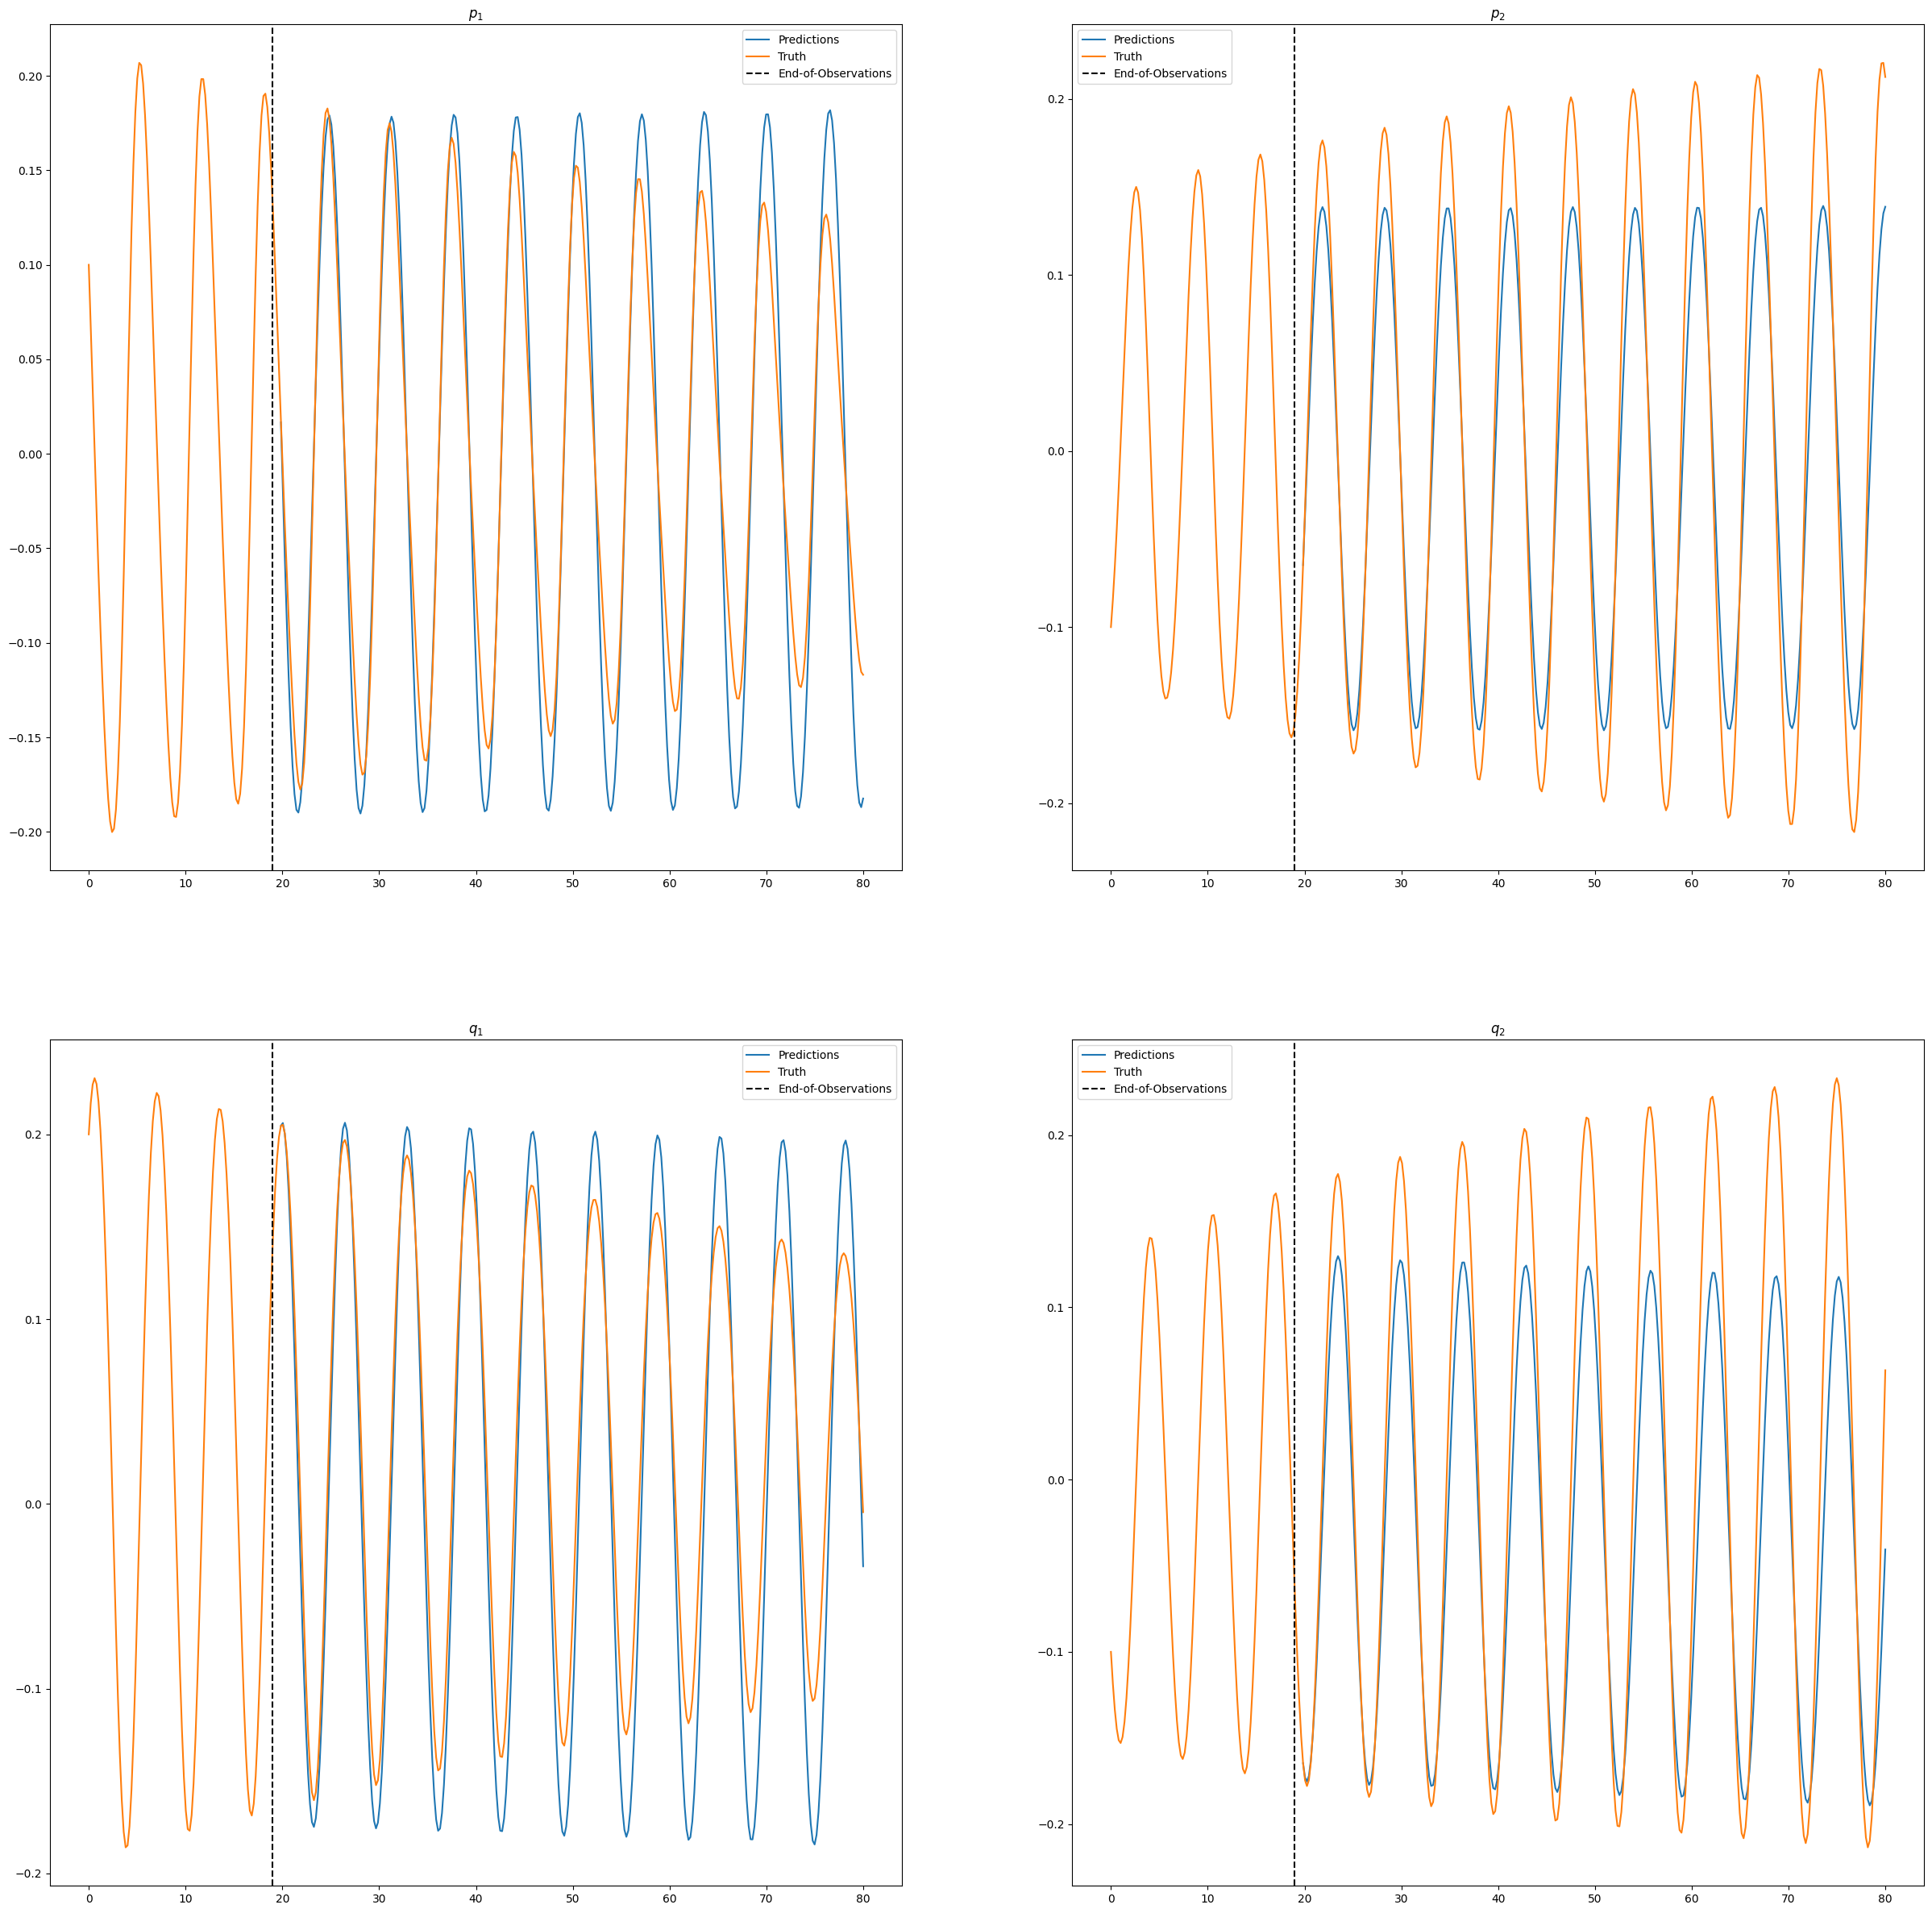

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "est", "truth", "label"])

plots_data = [
    PlotData((0, 0), pq_symplectic[:, 1, 0], p1, "$p_1$"),
    PlotData((0, 1), pq_symplectic[:, 1, 1], p2, "$p_2$"),
    PlotData((1, 0), pq_symplectic[:, 0, 0], q1, "$q_1$"),
    PlotData((1, 1), pq_symplectic[:, 0, 1], q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t[OBSERVATIONS_END - 1:], data.est, label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(19, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Nonliner Pendulum

## Data Generation

In [35]:
import jax
import jax.numpy as jnp
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

def H(p, q):
    return (0.5 * p ** 2) - jnp.cos(q)

def dq_H(p, q):
    return np.sin(q)

def dp_H(p, q):
    return p

p_dot = lambda p, q: -1 * dq_H(p, q)
q_dot = lambda p, q: dp_H(p, q)

def system_ode(pq, t):
    h_grad = [0, 0]
    p, q = pq
    h_grad[0] = -jnp.sin(q)
    h_grad[1] = p
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(system_ode, [0.0, 0.95*np.pi], t=t)

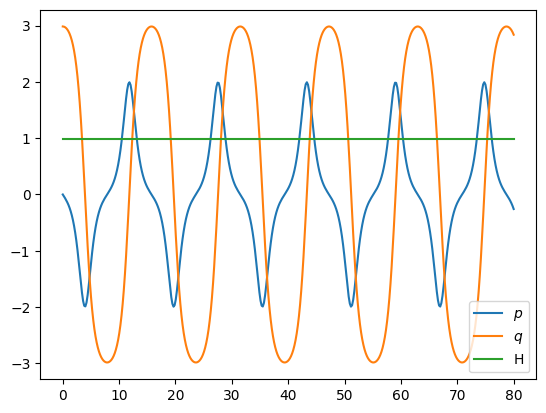

In [36]:
p, q = pq.T
H = H(p, q)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [37]:
OBSERVATIONS_END = 100
SPARSITY_FACTOR = 0.0

rng = np.random.default_rng(42)

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

rng = np.random.default_rng(seed=42)
M = np.ones_like(X_true).astype(bool)
sparse_mask = rng.choice([False, True], p=[SPARSITY_FACTOR, 1 - SPARSITY_FACTOR], size=OBSERVATIONS_END)
M[:OBSERVATIONS_END, 1] = sparse_mask
M[:OBSERVATIONS_END, 2] = sparse_mask
M[OBSERVATIONS_END:, 1:3] = False
M[:, 3] = False

rng = np.random.default_rng(42)
#X = rng.uniform(-0.15, 0.15, size=X_true.shape)
X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]

In [38]:
np_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

np_graph.add_observable("t")
np_graph.add_unknown_fn("t", "q", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})
np_graph.add_unknown_fn("t", "p", alpha=1e-5, kernel="gaussian", kernel_parameters={"scale": KP(1.0, learnable=True)})

np_graph.add_known_fn("p", "p_dot", derivative)
np_graph.add_known_fn("q", "q_dot", derivative)
np_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

np_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

np_graph.add_aggregator(["p", "q"], "pq")
np_graph.add_unknown_fn(
    "pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.001, kernel="big-kernel",
    kernel_parameters={
        "gaussian_width": KP(1.0, learnable=False),
        "gaussian_weight": KP(1.0, learnable=False, weight=False),
        "quadratic_constant": KP(1.0, learnable=False),
        "quadratic_weight": KP(1.0, learnable=False, weight=False),
        #"periodic_periodicity": KP(1.0 ,learnable=True),
        #"periodic_scale": KP(1.0, learnable=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        "cubic_constant": KP(1.0, learnable=False),
        "cubic_weight": KP(1.0, learnable=False, weight=True),
        #"cosine_weight": KP(1.0, learnable=True, weight=True),
        #"cosine_period": KP(1.0, learnable=True),
        #"periodic_weight": KP(1.0, learnable=True, weight=True),
        #"poly_weight": KP(1.0, learnable=True, weight=True),
        #"poly_constant": KP(1.0, learnable=True),
        #"poly_exponant": KP(2.0, learnable=False),
        #"locally_periodic_periodicity": KP(1.0, learnable=True),
        #"locally_periodic_scale": KP(1.0, learnable=True),
        #"locally_periodic_locality_scale": KP(1.0, learnable=True),
        #"locally_periodic_weight": KP(1.0, learnable=True, weight=True)
    }
)
#ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="polynomial", kernel_parameters={
#    "constant": KP(1.0, learnable=True),
#    "exponent": KP(2.0, learnable=False)
#})
#np_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=1, kernel="gaussian", kernel_parameters={
#    "scale": KP(1.0, learnable=True)
#})
np_graph.add_known_fn("H", "grad_H", derivative)

np_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
np_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

np_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
np_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [39]:
X_init, unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier = two_steps_initialization(np_graph, X, M, OBSERVATIONS_END)

In [40]:
mse_p = np.mean((X_true[OBSERVATIONS_END:, 1] - X_init[OBSERVATIONS_END:, 1]) ** 2)
mse_q = np.mean((X_true[OBSERVATIONS_END:, 2] - X_init[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 0.005438603940105256
Extrapolation MSE on Q = 0.01577299728905692


In [41]:
np_graph.set_loss_multipliers(unknown_functions_loss_multiplier, constraint_loss_multiplier, data_compliance_loss_multiplier)

In [42]:
Z = np_graph.complete(X_init, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=False, n_rounds=1)

 Loss: 47504.0645:   0%|          | 1634/1000000 [01:32<15:46:53, 17.57it/s]


In [43]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p}")
print(f"Extrapolation MSE on Q = {mse_q}")

Extrapolation MSE on P = 0.006214781970418058
Extrapolation MSE on Q = 0.016224094570144513


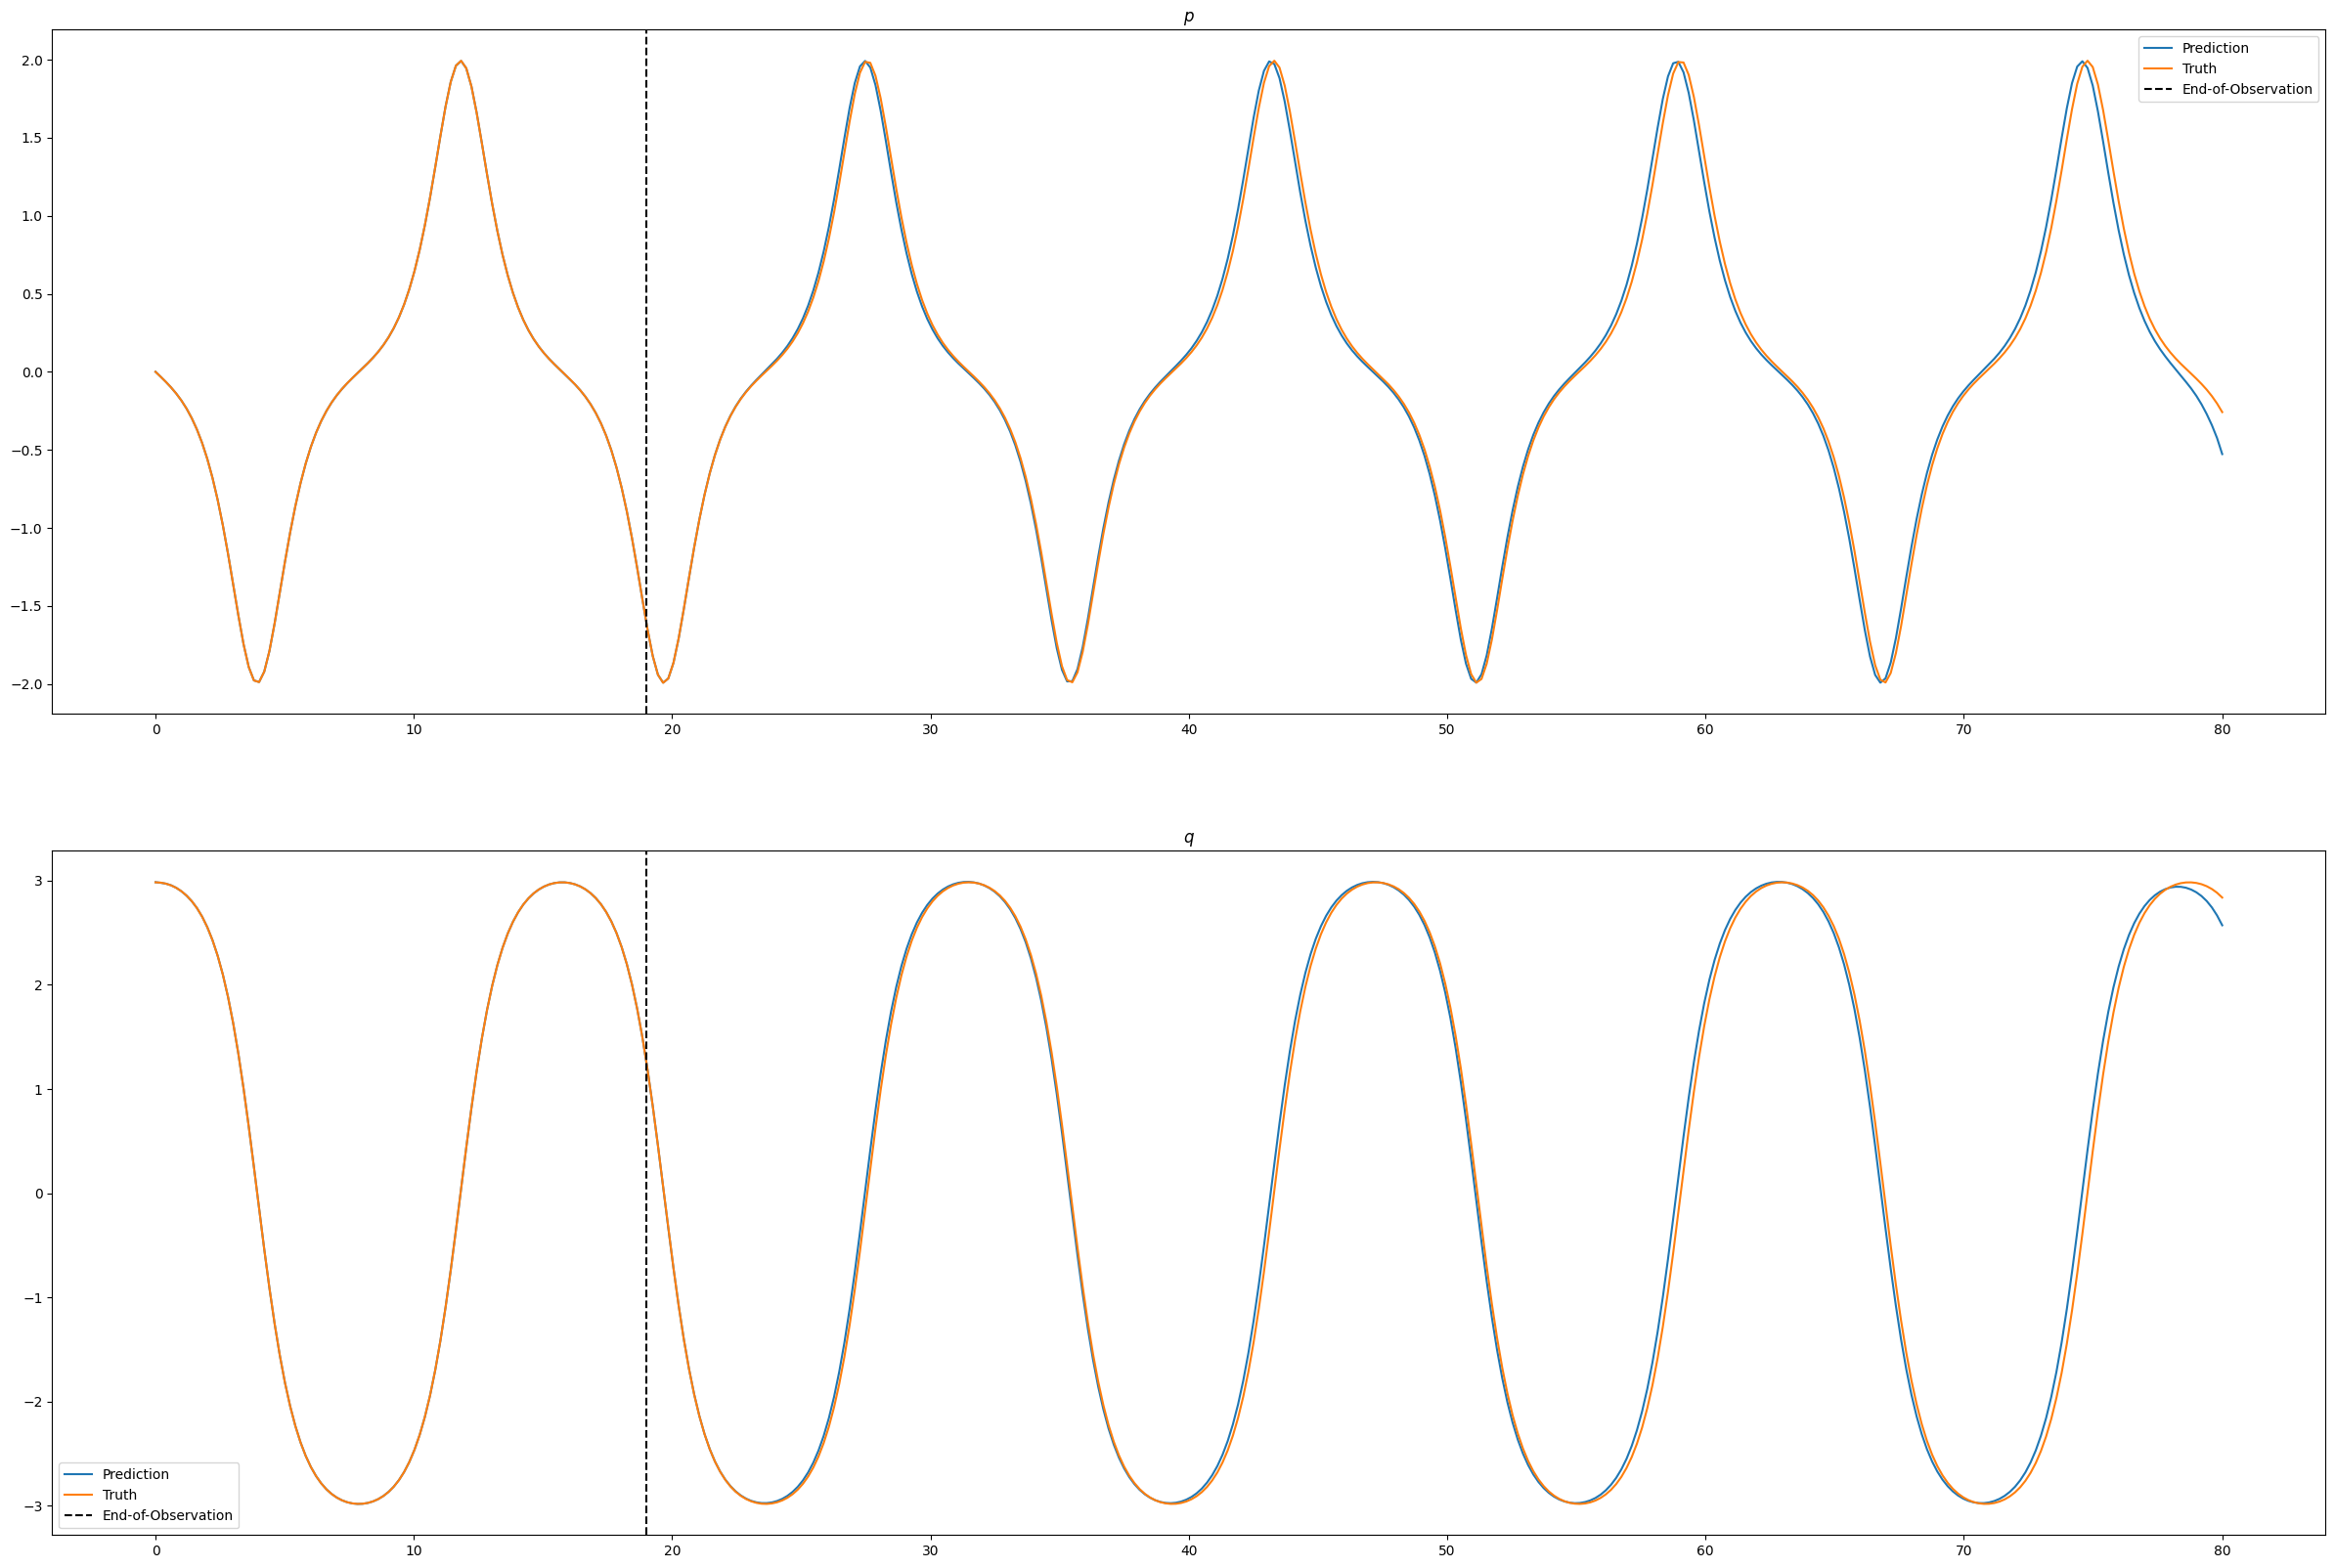

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(19, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

In [29]:
import numpy as np

np.int = int

H_np_est = get_hamiltonian_from(np_graph, Z)
H_np_est_grad = jax.jit(jax.grad(H_np_est))

start_point = [p[OBSERVATIONS_END - 1], q[OBSERVATIONS_END - 1]]

t = np.linspace(0, 80, 400)
pq_symplectic = hamiltonian_symplectic_int(H_np_est_grad, start_point, t[OBSERVATIONS_END - 1:])
pq_symplectic = jnp.squeeze(pq_symplectic)

In [30]:
mse_p = jnp.mean((p[OBSERVATIONS_END - 1:] - pq_symplectic[:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END - 1:] - pq_symplectic[:, 0]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 1.292168290
Extrapolation MSE on Q = 17.793454659


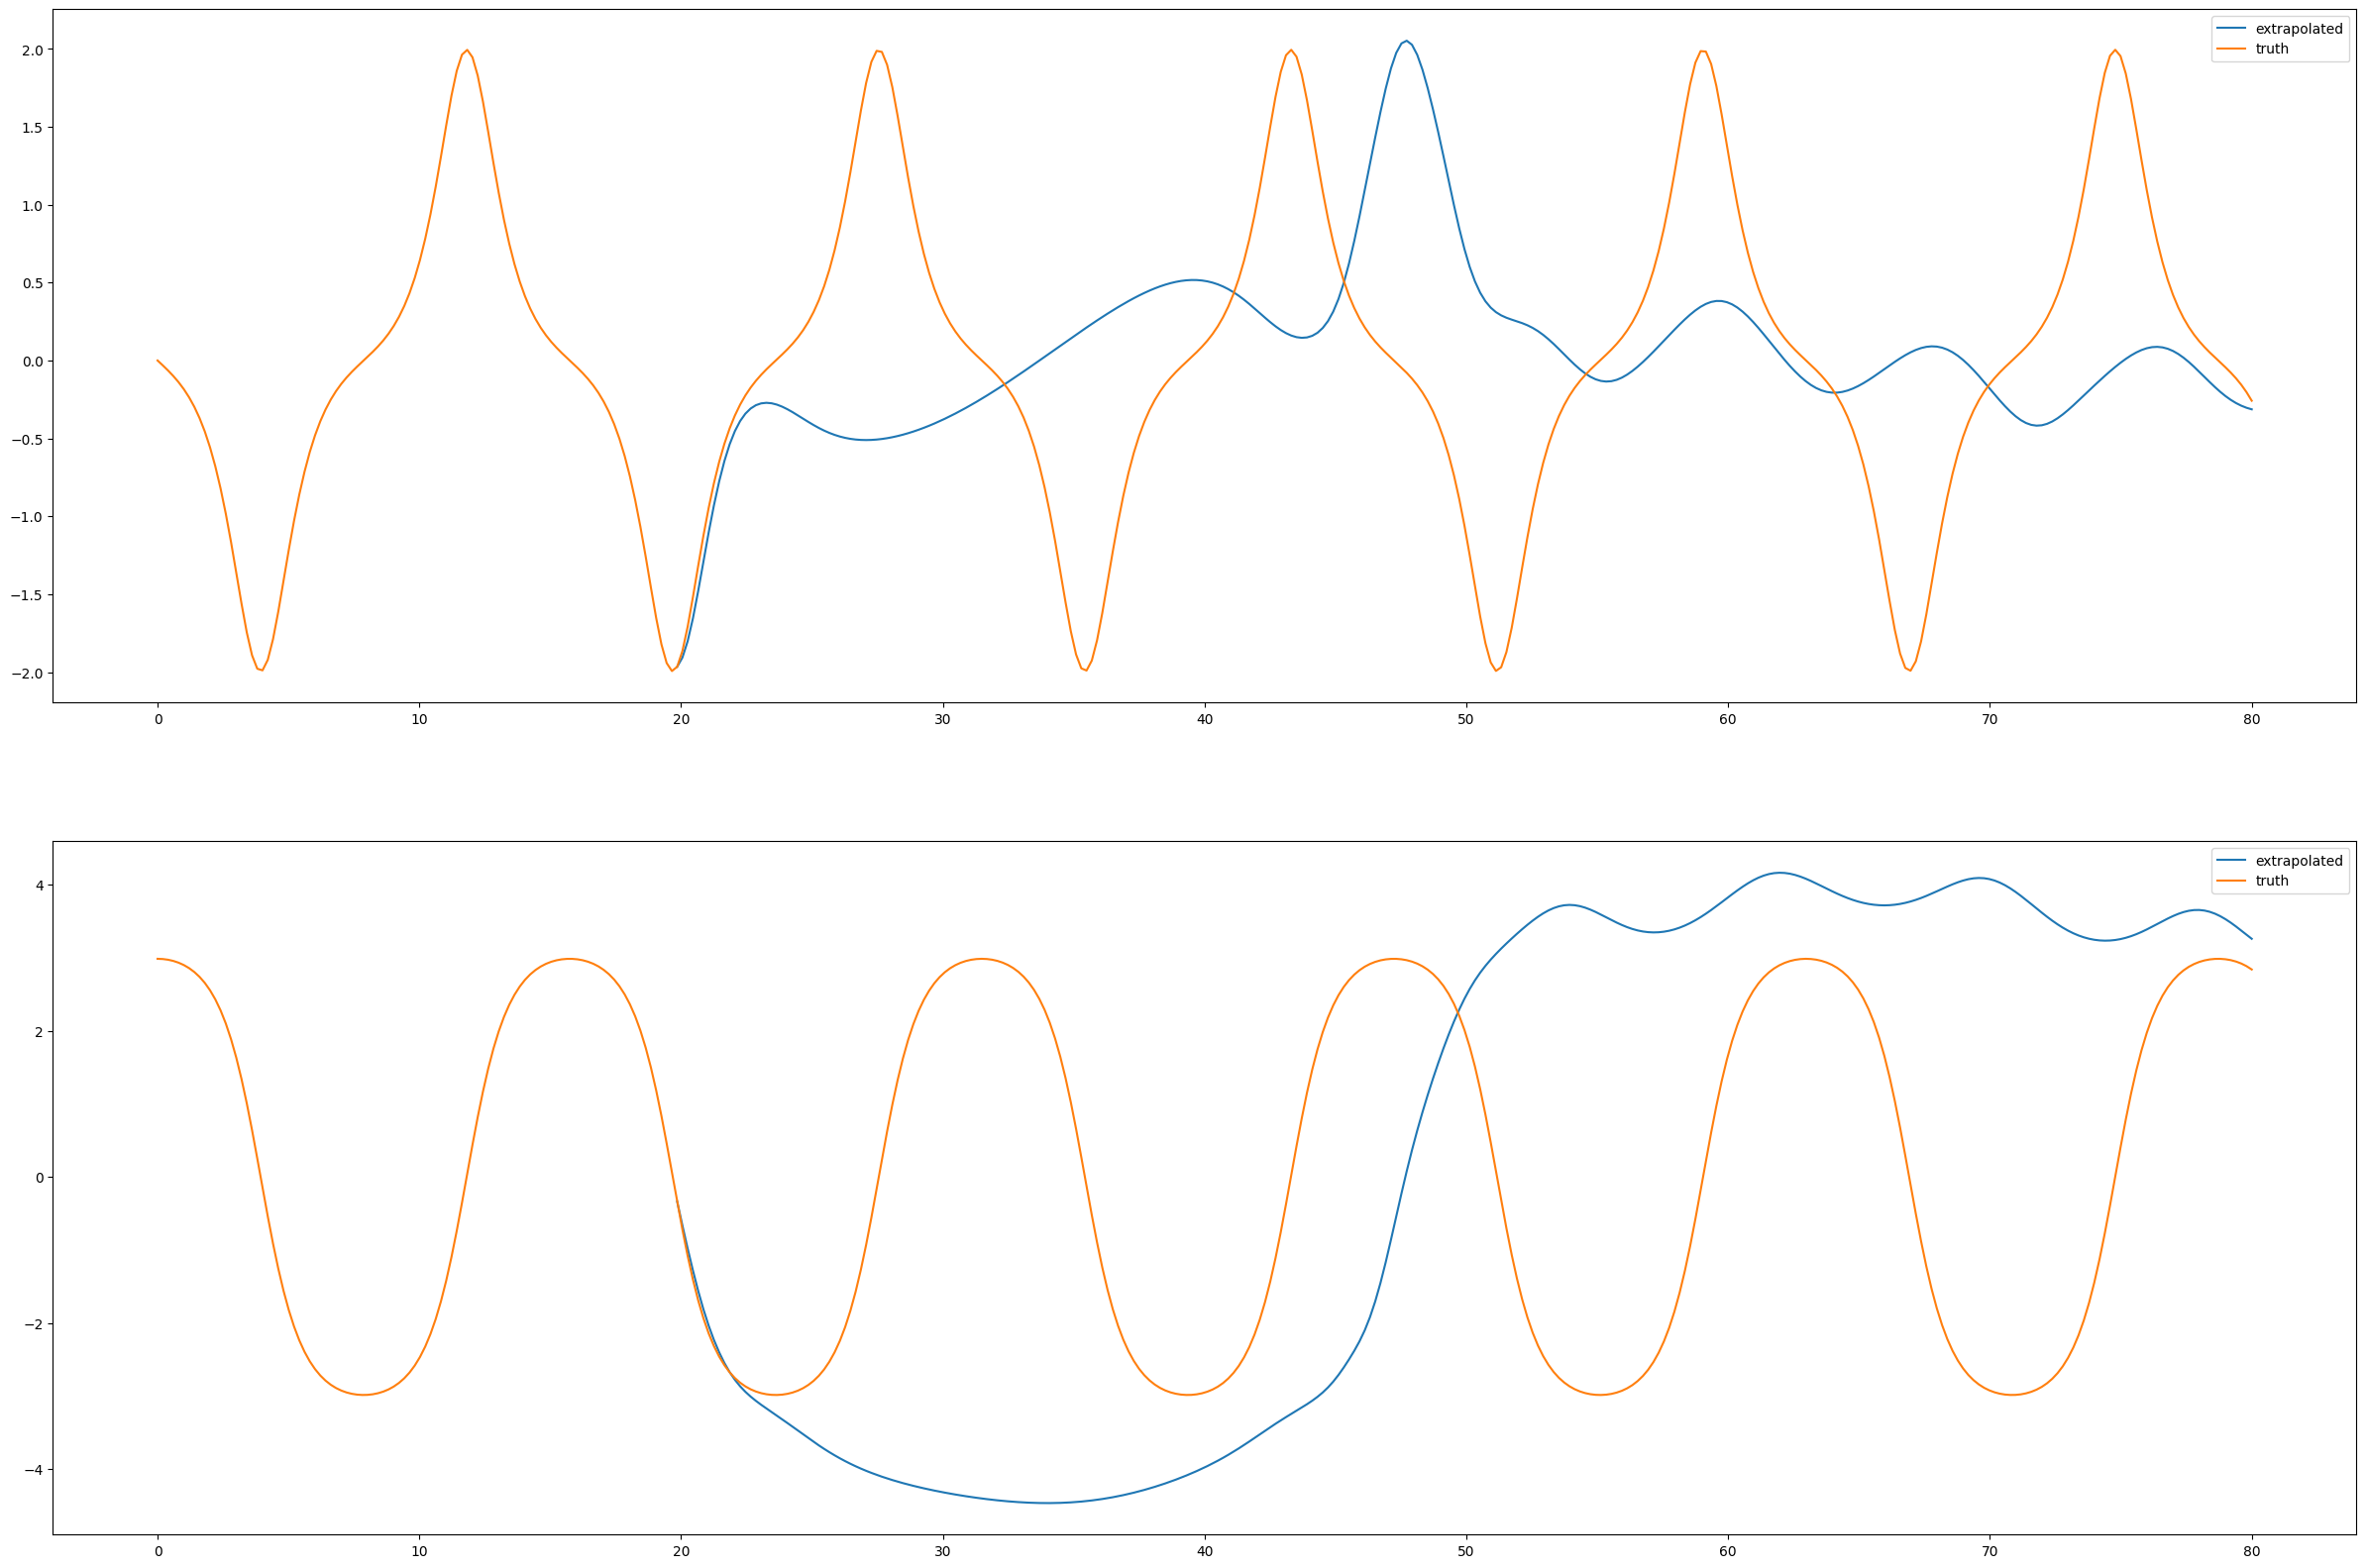

In [31]:
_, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t[OBSERVATIONS_END - 1:], pq_symplectic[:, 1], label="extrapolated")
axes[0].plot(t, p, label="truth")
axes[0].legend()
axes[1].plot(t[OBSERVATIONS_END - 1:], pq_symplectic[:, 0], label="extrapolated")
axes[1].plot(t, q, label="truth")
axes[1].legend()